<style>
    .div-1 {
        background-color: #EBEBEB;
    }
    
    .div-2 {
    	background-color: #ABBAEA;
    }
    
    .div-3 {
    	background-color: #FBD603;
    }
</style>

<div align="right"><img src='https://blockchain4talent.com/wp-content/uploads/2021/09/a58ab6e0efdce2743f592019683b00c2.jpeg'>

<h1 style="color:#2596be;font:luminary;text-align:center;"><i>Cisco Project</i></h1>

<div class=“alert alert-success”>

<h2 style="color:#2596be;">Project's Description</h1> 


This team will create a __Time Series Analysis__ model that will predict the sales for Cisco a year in the future. Our goal is to explore historical cisco sales to Texas public agencies (school districts, government agencies, municipalities, etc) to present to people who might want to invest into the cisco ecosystem. This can include potential stock investors or customers or even people looking to train to properly implement Cisco equipment.



In [1]:
# project modules
import wrangle as wr
import explore_Copy1 as ex
import summaries as s
#import ts_models_d as tsmd

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# makes vizualizations better in a jupyter notebook
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np

# models
import statsmodels.api as sm
import xgboost as xgb
# pmdarima and prophet need installation!
#import pmdarima as pm # pip install pmdarima
import prophet # python -m pip install prophet
#from prophet import Prophet
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima.utils import ndiffs

from sklearn.metrics import mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


# import graphic modules
import matplotlib.pyplot as plt
import seaborn as sns

/Users/yvetteibarra/codeup-data-science/cisco-time-series-analysis/yvette_ibarra/wrangle.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['order_date'] = temp_df['order_date'] +  pd.offsets.DateOffset(years=1)
/Users/yvetteibarra/codeup-data-science/cisco-time-series-analysis/yvette_ibarra/wrangle.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['order_date'] = temp_df['order_date'] +  pd.offsets.DateOffset(years=1)


In [2]:
raw = wr.acquire_data()
raw[['customer_name','order_date']]

,customer_name,order_date
981291,Texas Department of Public Safety,03/02/2021
981292,Texas Department of Public Safety,03/02/2021
981293,Texas Department of Public Safety,03/02/2021
981294,Texas Department of Public Safety,03/02/2021
981295,Texas Department of Public Safety,03/02/2021
...,...,...
7367053,Lamar Consolidated Independent School District,06/15/2022
7367054,Lamar Consolidated Independent School District,06/15/2022
7367055,Lamar Consolidated Independent School District,06/15/2022
7367056,Lamar Consolidated Independent School District,06/15/2022


In [3]:
df = wr.get_clean_data()

In [ ]:
sum_df =s.get_summary_df(df)

In [ ]:
miss,_=wr.split_data(sum_df)

In [ ]:
miss

In [ ]:
train.to_csv("train.csv")

In [ ]:
def drop2017_and_move2016_up(df):
    '''
    This function drops missing year 2017 to combine data with 2018+ dataframe. This is done by creating a temporary
    dataframe and adding a year to years 2014-2016 to creates a seam between 2016 and 2018. 
    return dataframe with new years for temp_df
    '''
    before2017 = df.loc[:'2016'].copy()
    after2017 = df.loc['2018':].copy()
    before2017.index = (before2017.index + pd.Timedelta('1 Y') ).normalize()
    
    return pd.concat([before2017, after2017], axis=0)

In [ ]:
new_data = drop2017_and_move2016_up(train)

In [ ]:
new_data.to_csv('new_date.csv')

<h3 style="color:#2596be;">Acquire and Prepare</h3> 

We acquired the data from the [Texas Open Data Portal](https://data.texas.gov/dataset/OFFICIAL-DIR-Cooperative-Contract-Sales-Data-Fisca/w64c-ndf7). The origin of the data is 	[Texas Department of Information Resources](	https://dir.texas.gov/). The data file contains information about DIR (Department of Information Resources) Cooperative Contract Sales. To get the information about Cisco we filtered the data by vendor name.

- Our first cleaning step was dropping the  7 columns with null values only and renaming columns into programming friendly format simply by replacing whitespaces with underscores and making them lower case. Our next step was dropping columns with no value for exploration or modeling purposes (for example, `vendor_adress`, `reseller_phone` etc.)
- We have created additional features based on the `order_date` information:
    `year` : year
    `quarter`: quarter
    `month`: month number
    `month_name`: month name
    `day_of_week`: day of week number
    `day_name`: day of week name
    `day_of_year`: day of the year
    `week`: week of the year number

The original data contains the accounting information about every transaction where every row represents a transaction. One company could have many transactions per day, including those where the `purchase_amount` was equal to zero, one cent or being negative. We have created as well a summary data frame whith the final `purchase_amount` per day per company. This combined the number of rows from 261,886 to 34,401 rows. 
- Outliers were kept for this iteration of explore of modeling.

- To avoid data leakagee divided the data into train and test sets. 
- After the exploration we split the test set into validation and test sets as well.
- __The target variable of the project is ```purchase_amount```__


<h3 style="color:#2596be;">Data Exploration</h3> 

Before we jump into Data Exploration, let's have a look at the customer types represented in our data. We can see that most orders are made by Local Goverments, followed by  Independent School Districts, Higher Education Institutions and State Agencies. Other public agencies make only 0.6% orders.

In [4]:
##### get the data
df = s.get_summary_df(wr.get_clean_data(start2018=False))
# define target vaiable
target = 'purchase_amount'
#### split into train, validate, test sets
train, test = wr.split_data(df)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':].copy()
# get time series with the daily resample
X_train_ts = train.purchase_amount.copy().resample('D').sum()
X_validate_ts = validate.purchase_amount.copy().resample('D').sum()
X_test_ts = test.purchase_amount.copy().resample('D').sum()
# data frames out of the TS
X_train = X_train_ts.to_frame()
X_validate = X_validate_ts.to_frame()
X_test = X_test_ts.to_frame()

In [5]:
plt.style.use("seaborn-whitegrid") # returns warnings
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
#plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.rcParams.update({'figure.dpi':120})
#%config InlineBackend.figure_format = 'retina'

# set default parameters for floats
pd.options.display.float_format = '{:,.2f}'.format

In [6]:

#plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

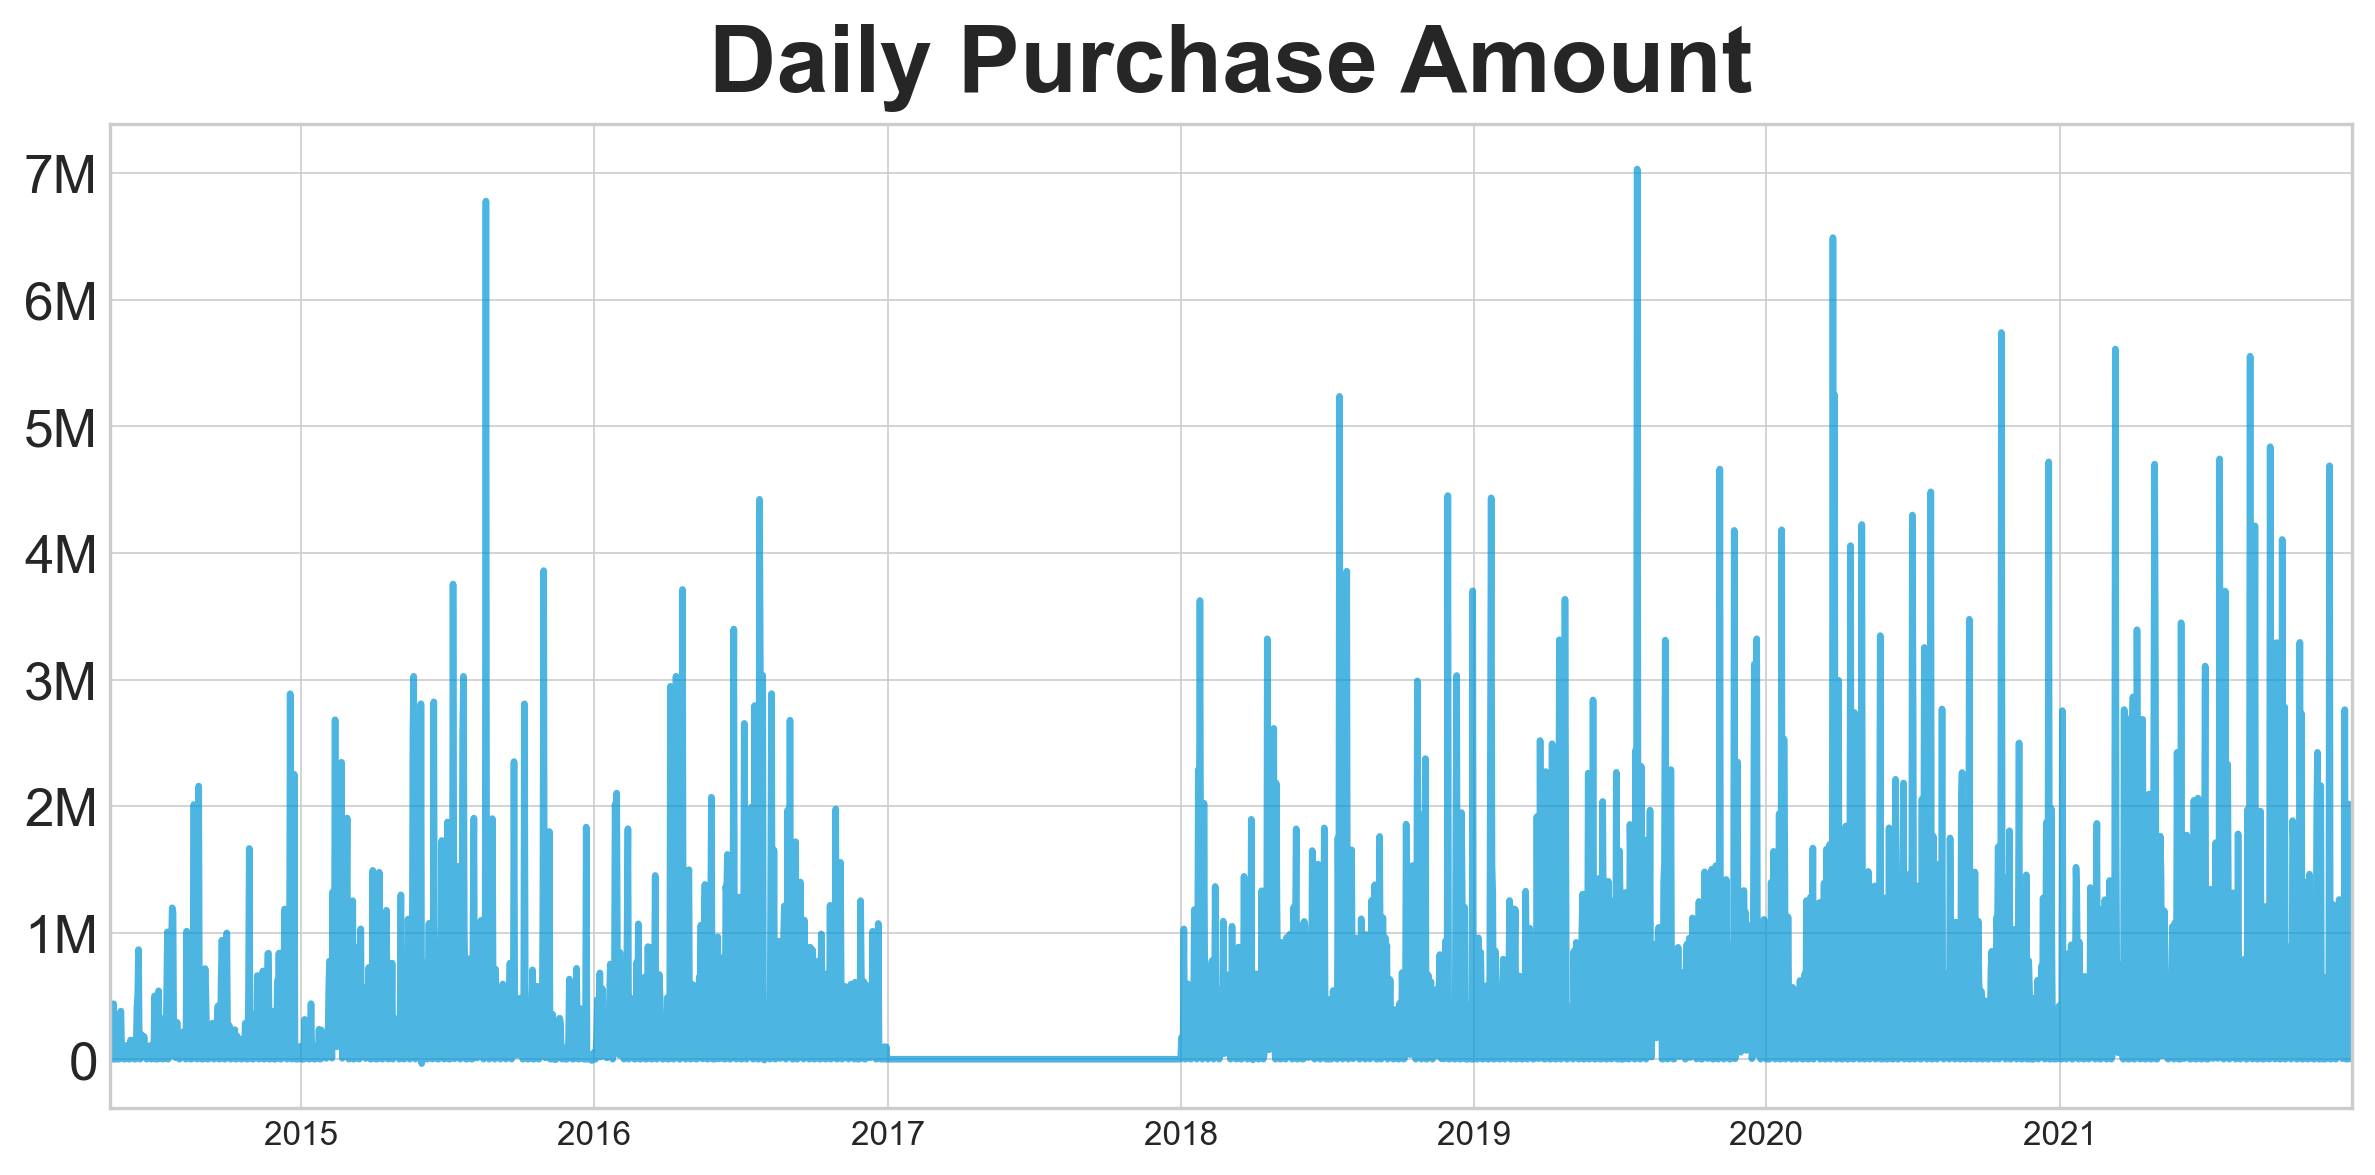

In [7]:
# show daily sales visualization
def show_ts():
    '''
    plots daily sales for the X_train
    '''
    plt.figure(figsize = (10,5))
    ax  = X_train_ts.plot(alpha=0.7,color='#0296D7')
    plt.title('Daily Purchase Amount',size=28,fontweight="bold")
    ax.set(yticks=[0, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000, 6_000_000, 7_000_000])
    ax.set(yticklabels=['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M'])
    ax.yaxis.set_tick_params(labelsize=16, color ='black')
    ax.set_xlabel('')
  
    plt.show()
show_ts()

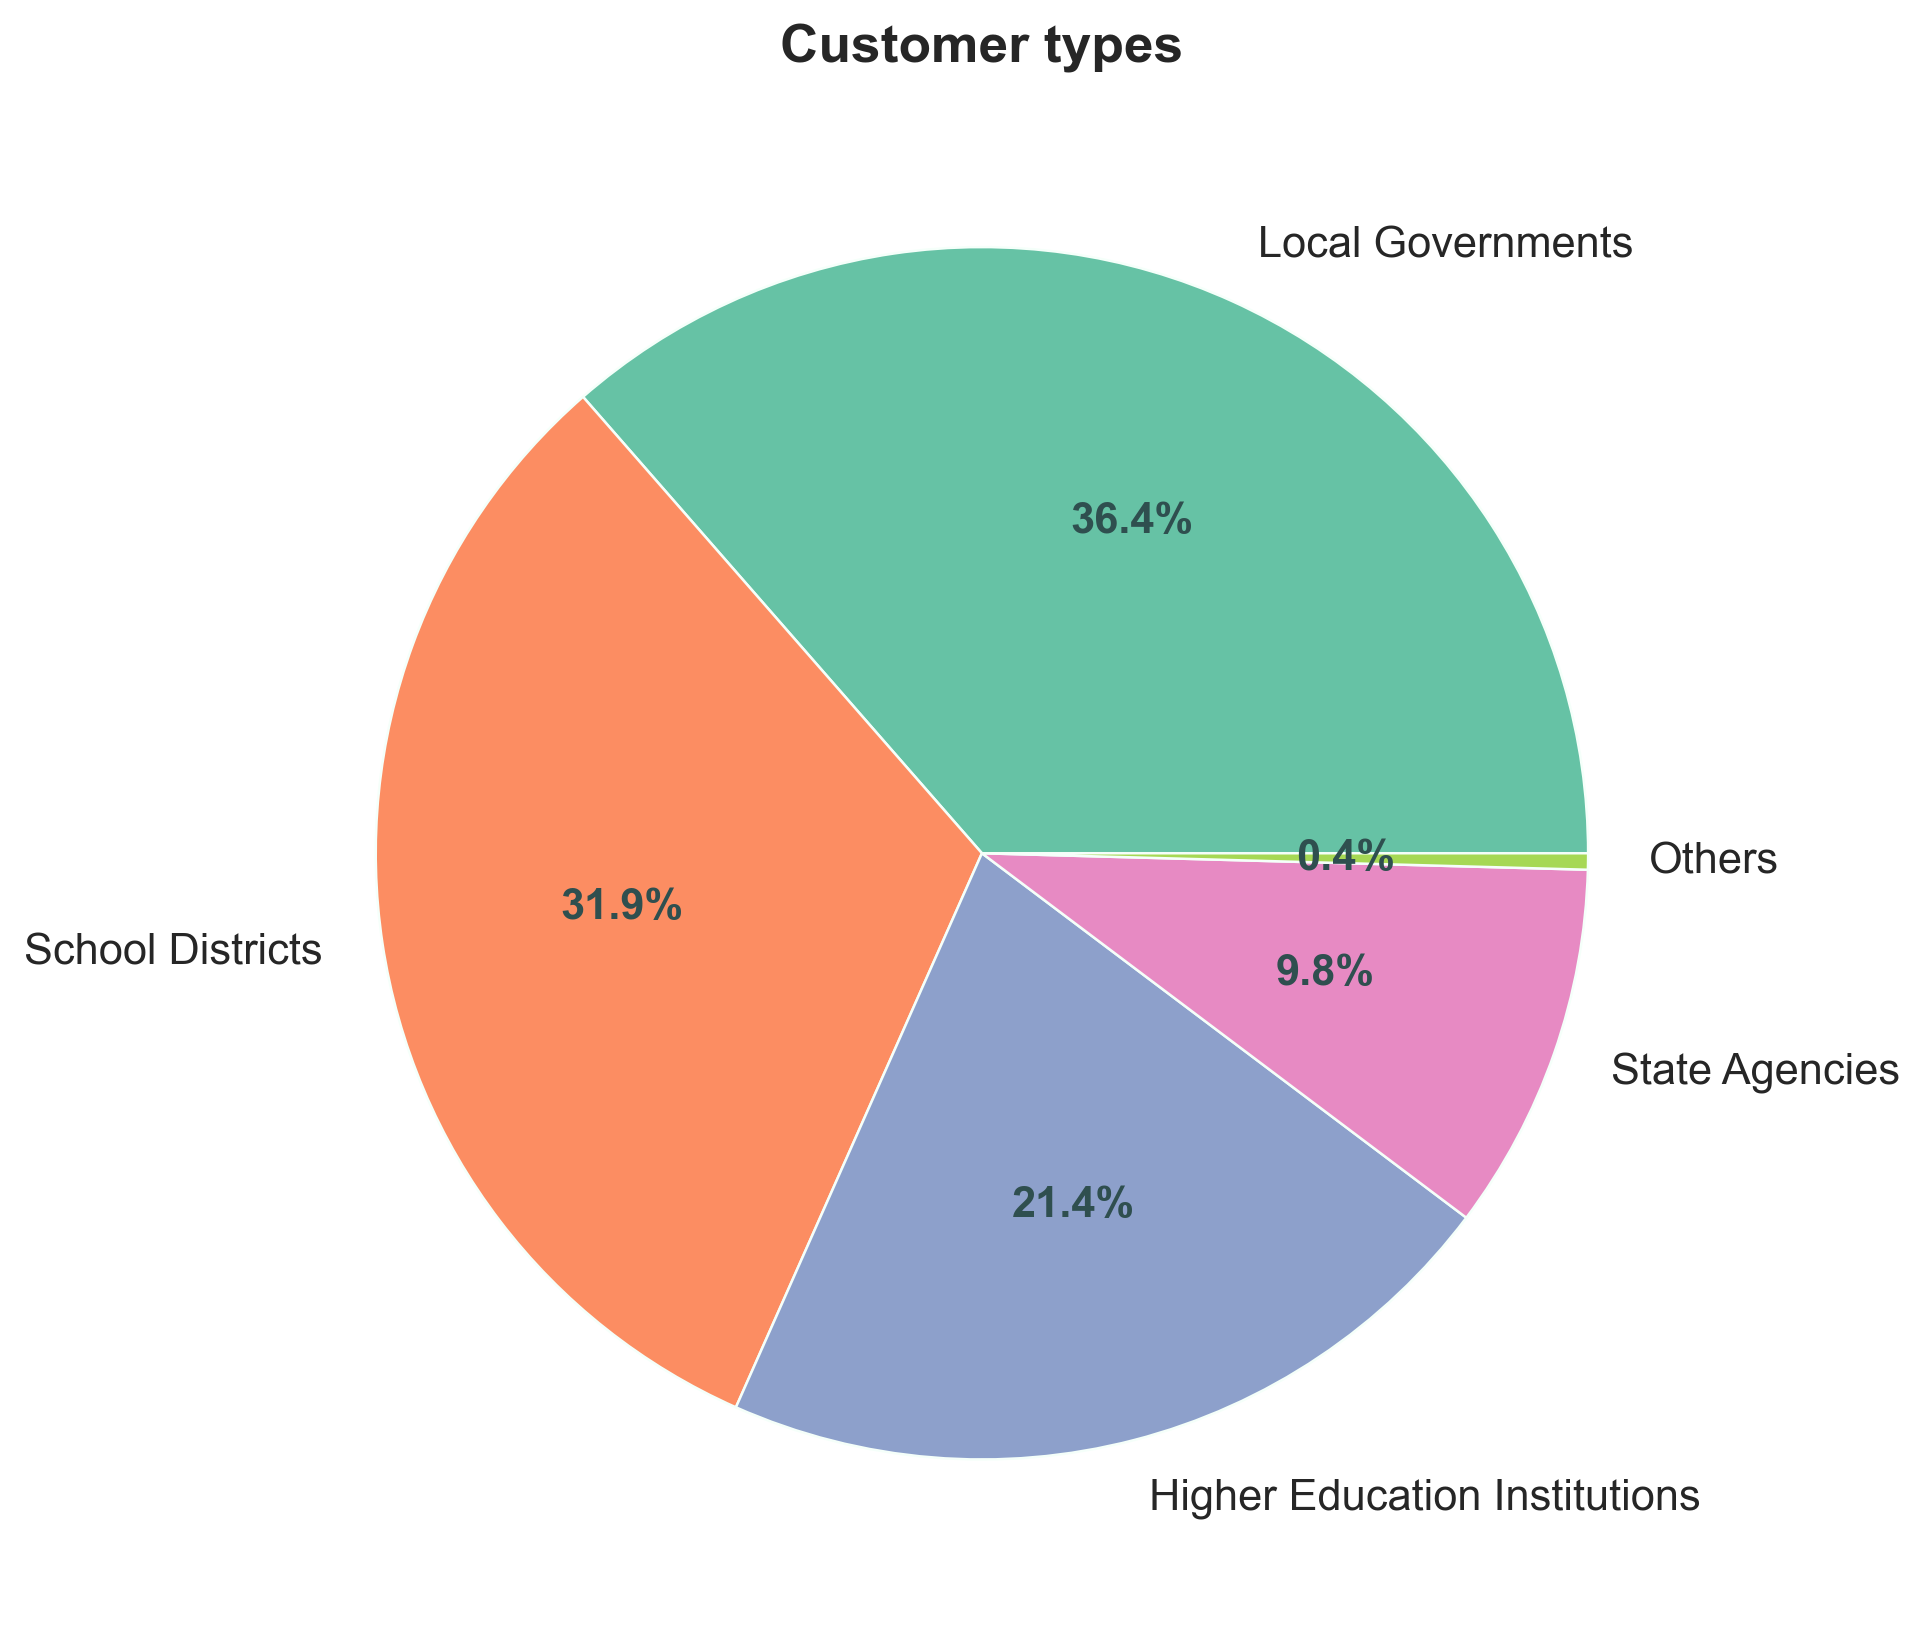

In [8]:
# call pie chart with 


def autopct_format(values):
    '''
    the function accept value_counts from outcome_type
    puts it in % format ready to use in pie charts
    '''
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%'.format(pct, v=val)
    return my_format

def viz_customer_types():
    '''
    the function creates a pie chart for customer types 
    '''
    piechart_labels = ['Local Governments','School Districts', 'Higher Education Institutions', 'State Agencies', 'Others']
    values = train.customer_type.value_counts(normalize=True).tolist()
    plt.figure(figsize=(8, 8))
    
    patches, texts, pcts = plt.pie(values, labels=piechart_labels,
            colors=sns.color_palette('Set2'), autopct=autopct_format(values),
            shadow=False, textprops={'fontsize': 13},wedgeprops = { 'linewidth' : .75, 'edgecolor' : 'mintcream' }) 
    
    plt.setp(pcts, color='darkslategray', fontweight='bold')
    plt.title('Customer types')
    plt.show()




viz_customer_types()

In [9]:
ct_df= pd.DataFrame(train.customer_type.value_counts(normalize=True))
ct_df['group']=ct_df.index
#df = df['col_name'].replace({'G': 1})
ct_df['group']=ct_df['group'].replace({"K-12":"School Districts", "Higher Ed":"Higher Education", 
                                       "Local Government":'Local Governments', "State Agency":"State Agencies"})
ct_df = ct_df.drop(labels = "Other", axis = 0)
#data = data.drop(columns=data.columns[3])
ct_df

,customer_type,group
Local Government,0.36,Local Governments
K-12,0.32,School Districts
Higher Ed,0.21,Higher Education
State Agency,0.10,State Agencies


In [10]:
colors = ['#7d6f9e', '#4585ab', '#486d2d', '#b9601c', '#c285a8', '#6bb4d5']
#purple, maroon, blue, green, orange, pink, light blue

In [11]:
pal = sns.color_palette('Blues', 5)
pal.as_hex()

['#d6e6f4', '#abd0e6', '#6aaed6', '#3787c0', '#105ba4']

In [12]:
pal.as_hex()[:]

['#d6e6f4', '#abd0e6', '#6aaed6', '#3787c0', '#105ba4']

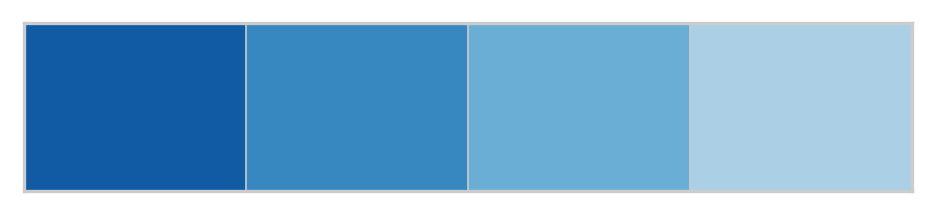

In [13]:
#use html color codes
Blue2 = ['#105ba4', '#3787c0' ,'#6aaed6' ,'#abd0e6']
sns.palplot(sns.color_palette(Blue2))

In [14]:

# libraries
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import pandas as pd
import matplotlib
# Create a data frame with fake data
#df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })

# plot it
#squarify.plot(sizes=ct_df['customer_type'], 
#color=["#0296D7", "#73984E","#B28542","#9C80CA", 'gray'], alpha=.4 )
cmap = matplotlib.cm.Blue2
mini=min(ct_df.customer_type)
maxi=max(ct_df.customer_type)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [Blue2(norm(value)) for value in ct_df.customer_type]

plt.figure(figsize=(7,5))
new_line = '\n'
perc = [f'{i/ct_df["customer_type"].sum()*100:5.0f}%' for i in ct_df["customer_type"]]
lbl = [f'{el[0]}{new_line}  {el[1]}' for el in zip(ct_df['group'], perc)]
squarify.plot(sizes=ct_df["customer_type"],color=colors,
              label=lbl, alpha=.7 ,text_kwargs={'color':'black', 'size':14},pad=True)

plt.title('Customer Types', fontsize = 25)
plt.axis('off')
plt.show()

AttributeError: module 'matplotlib.cm' has no attribute 'Blue2'

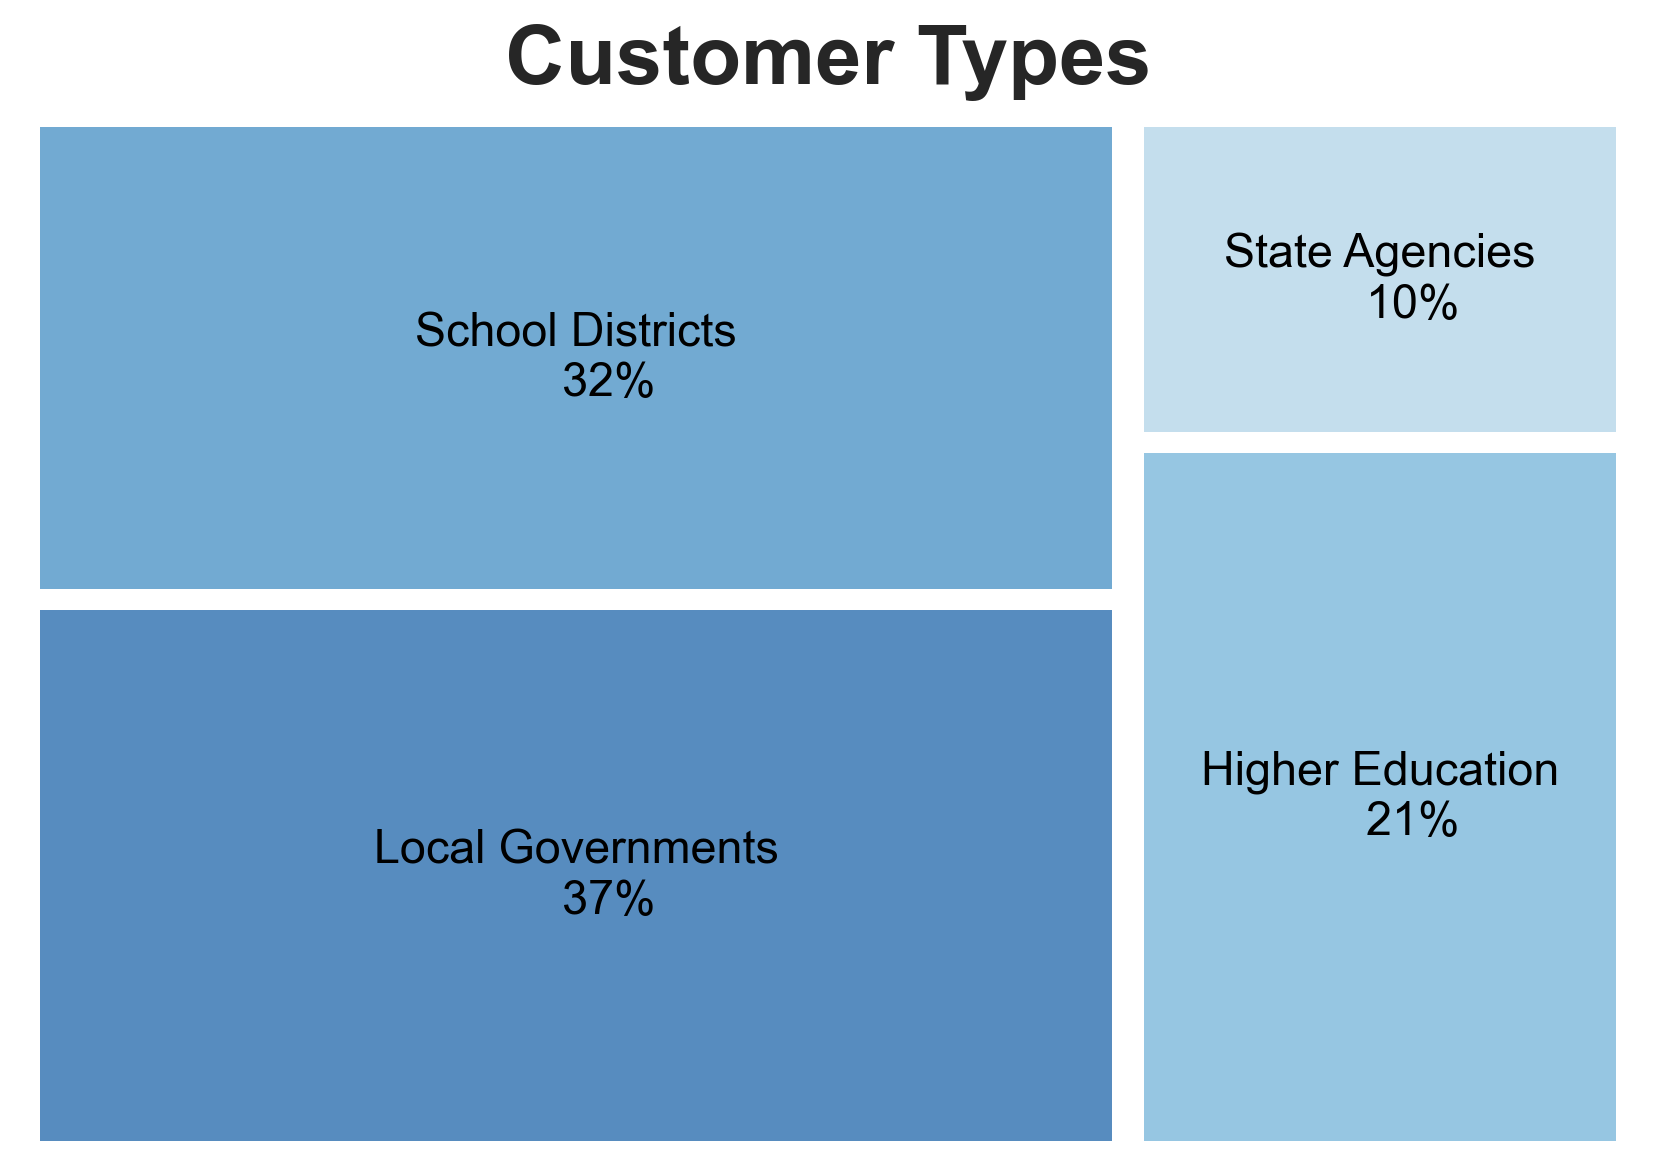

In [15]:

# libraries
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import pandas as pd

# Create a data frame with fake data
#df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })

# plot it
#squarify.plot(sizes=ct_df['customer_type'], 
#color=["#0296D7", "#73984E","#B28542","#9C80CA", 'gray'], alpha=.4 )
plt.figure(figsize=(7,5))
new_line = '\n'
perc = [f'{i/ct_df["customer_type"].sum()*100:5.0f}%' for i in ct_df["customer_type"]]
lbl = [f'{el[0]}{new_line}  {el[1]}' for el in zip(ct_df['group'], perc)]
squarify.plot(sizes=ct_df["customer_type"],color=Blue2,
              label=lbl, alpha=.7 ,text_kwargs={'color':'black', 'size':14},pad=True)

plt.title('Customer Types', fontsize = 25)
plt.axis('off')
plt.show()

### 1. Is there any significant difference in average of total purchase amounts by  day?

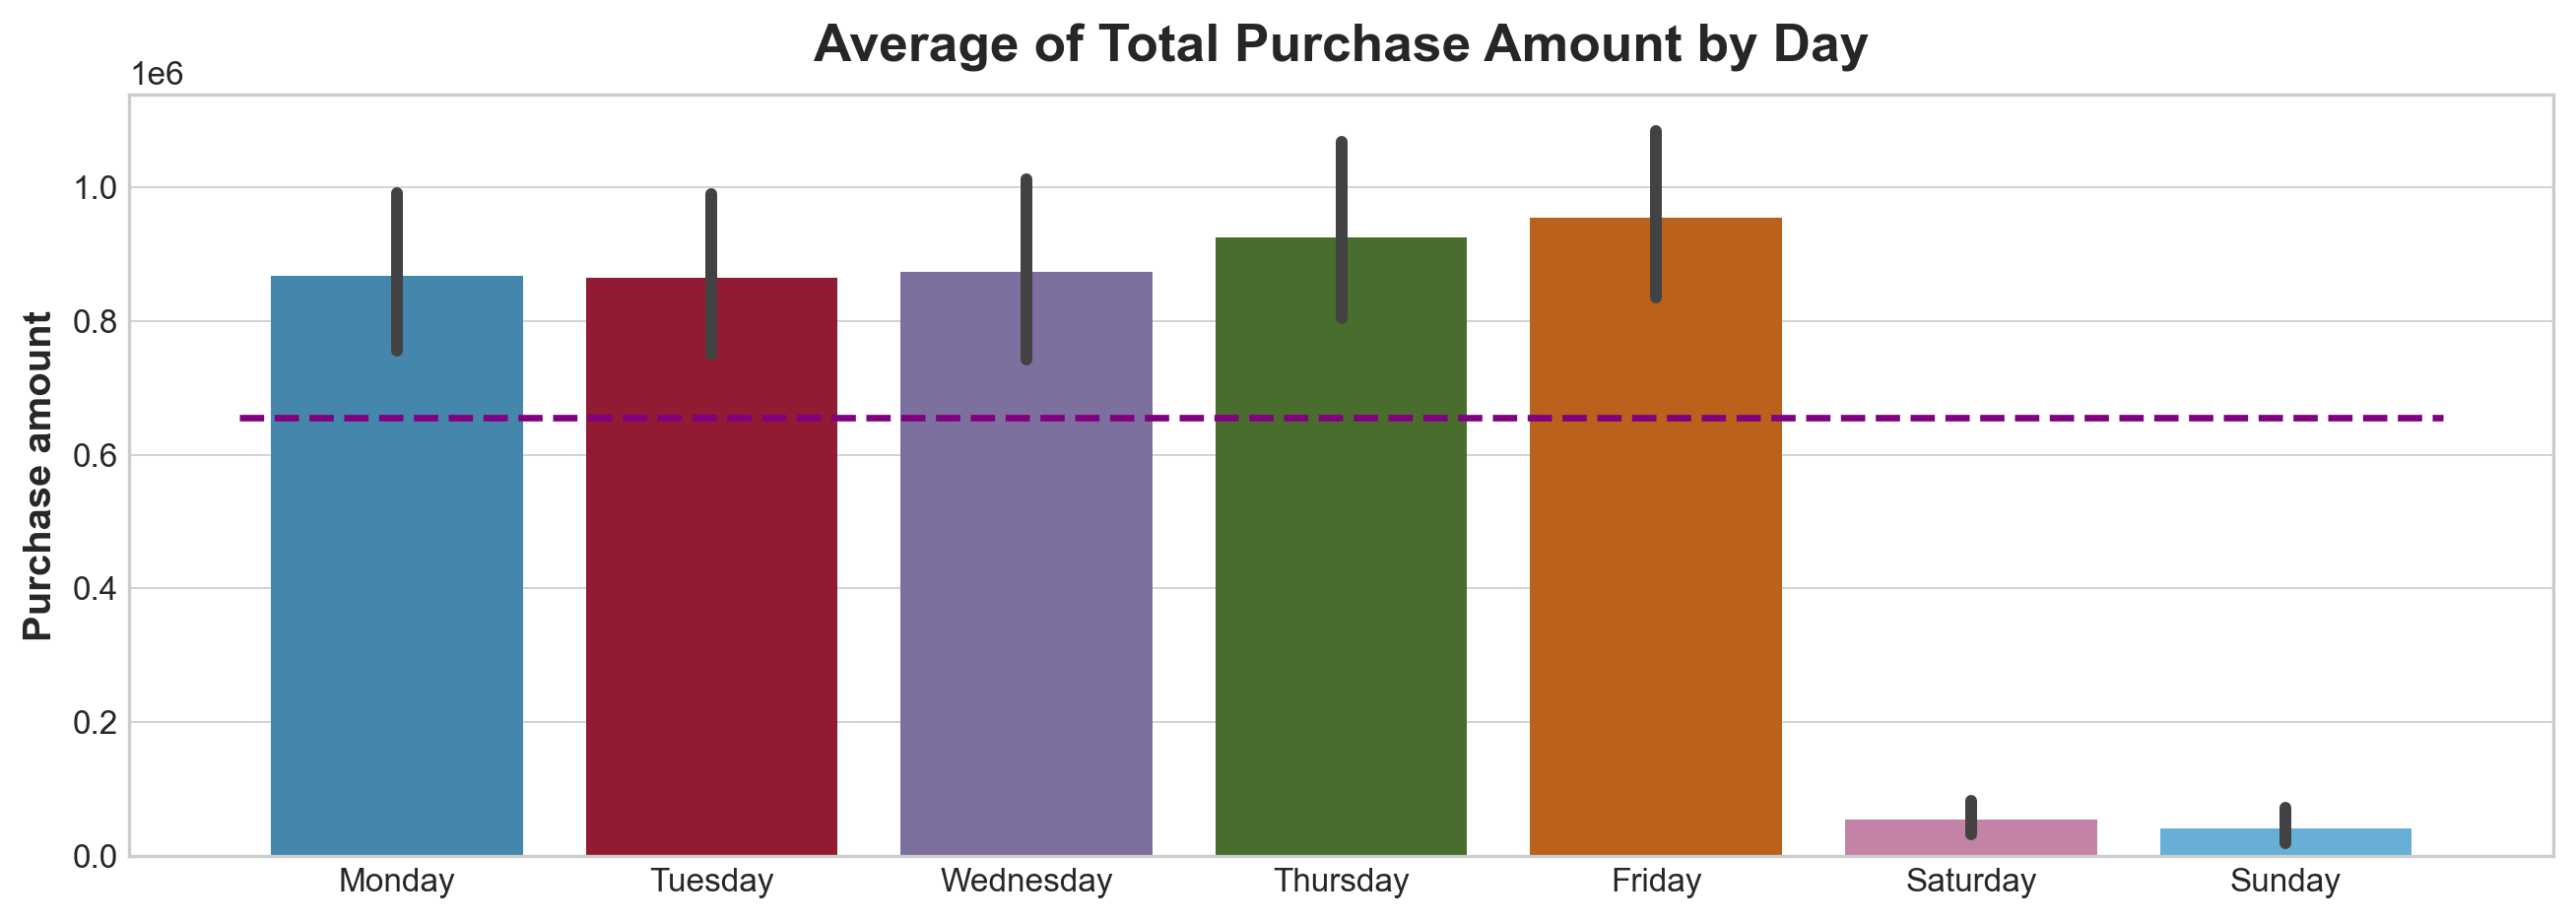

In [16]:
# visualize average sales per day
ex.q1_viz()

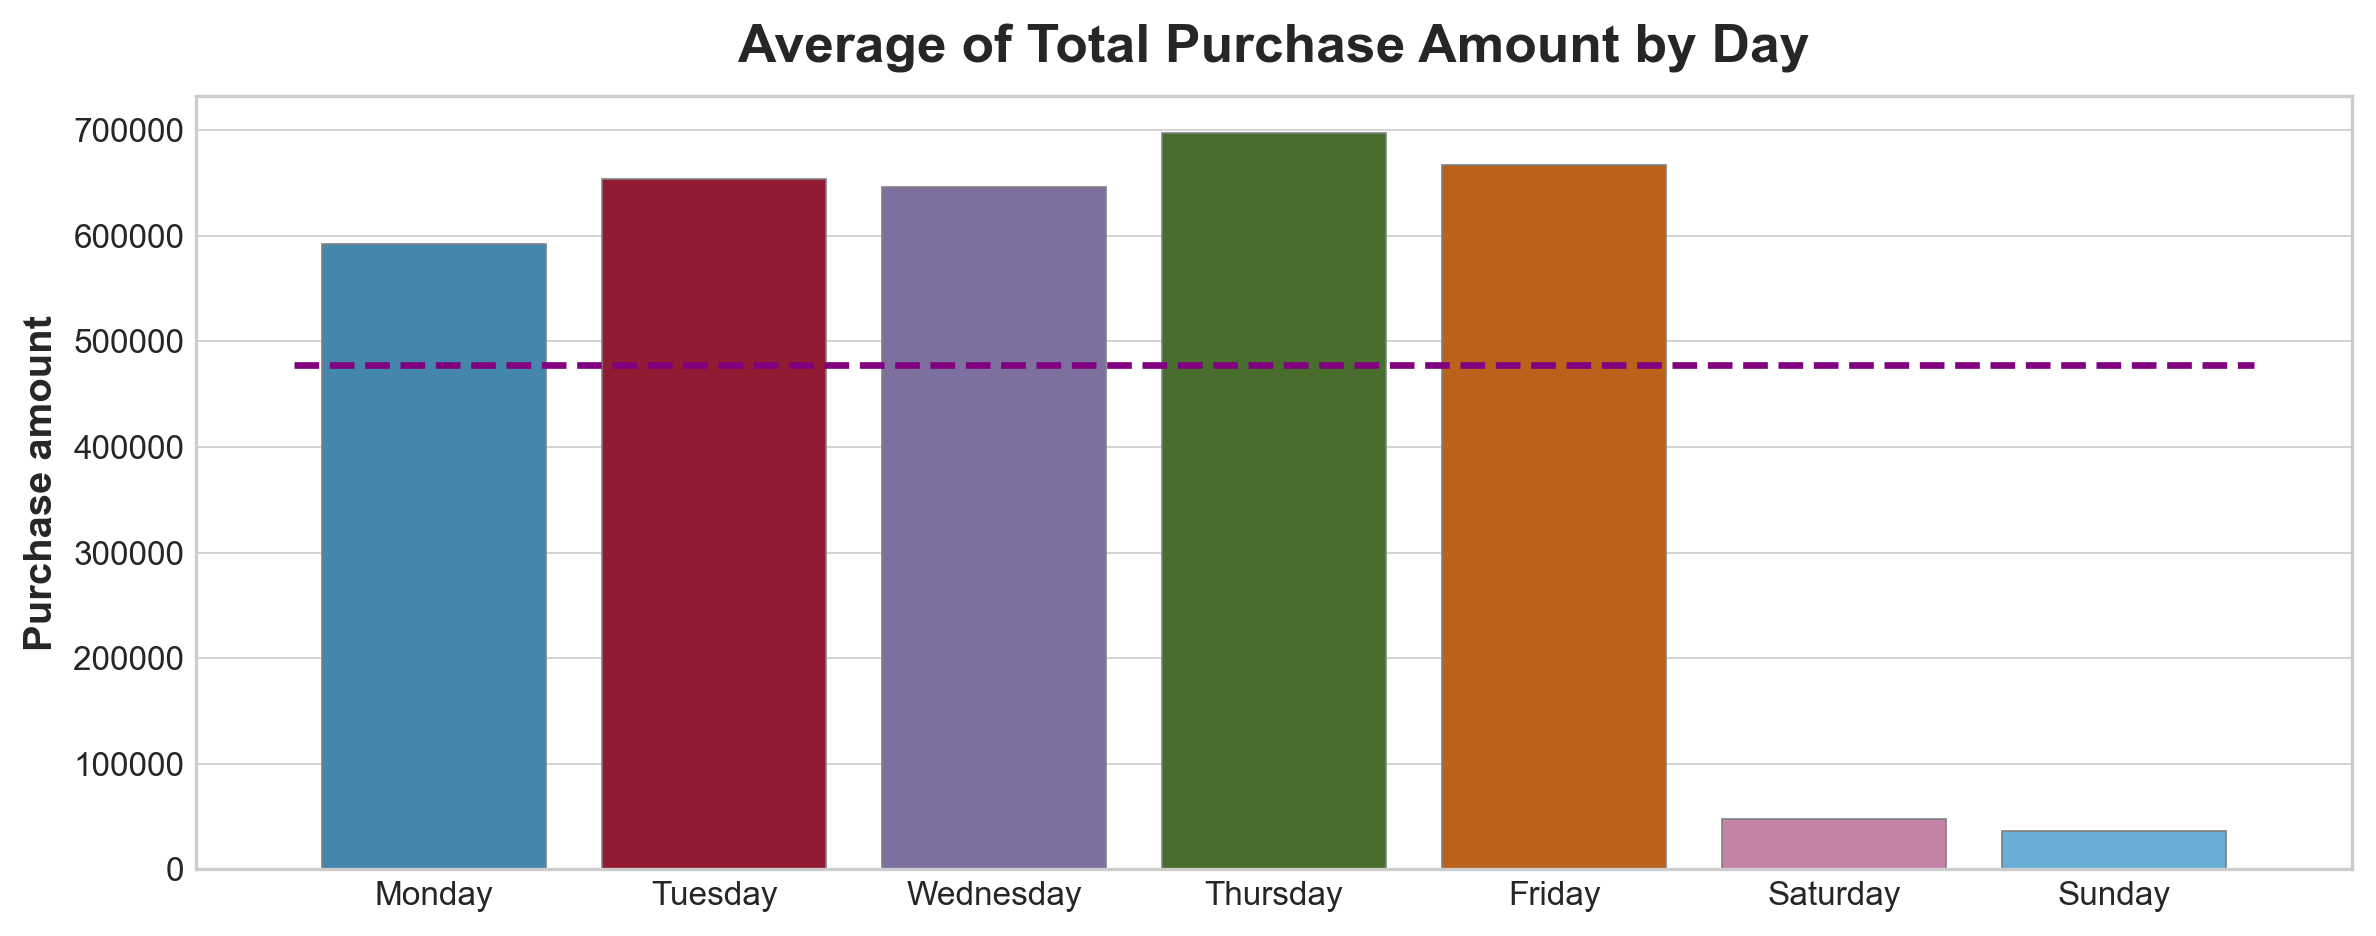

In [17]:
train_ts = train.purchase_amount.resample('D').sum().to_frame()
# add date features to train_ts
train_ts = wr.add_date_features(train_ts)

# separate by day for stat test
mon = train_ts[train_ts.day_name == 'Monday']
tue = train_ts[train_ts.day_name == 'Tuesday']
wed = train_ts[train_ts.day_name == 'Wednesday']
thu = train_ts[train_ts.day_name == 'Thursday']
fri = train_ts[train_ts.day_name == 'Friday']
sat = train_ts[train_ts.day_name == 'Saturday']
sun = train_ts[train_ts.day_name == 'Sunday']

# create a df with total purchase amount of the month
train_m = train.purchase_amount.resample('M').sum().to_frame()
# add month name
train_m['month_name'] = train_m.index.month_name()

# create a df with total purchase amount of the month
train_q = train.purchase_amount.resample('3M').sum().to_frame()
# add month name
train_q['month_name'] = train_q.index.month_name()
train_q['quarter'] = train_q.index.quarter

# alpha 0.05 for condidence level 95%
alpha = 0.05

#creating a dataframe for the 'pandemic year'
train_pdf,_ = wr.split_data(wr.get_clean_data(start2018=True))
pandemic_df = train_pdf.loc[train_pdf.index >= '11-01-2019']
def q1_viz():
    plt.figure(figsize=(10,4))
    
    # order for graphs
    months =['January', 'February', 'March', 'April', 
             'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # visualize 
    ax = sns.barplot(data = train_ts, x='day_name', y='purchase_amount', order=days,edgecolor='gray',ci=False)
    plt.xlabel('')
    plt.ylabel('Purchase amount')
    x_left, x_right = ax.get_xlim()
    ax.hlines(train_ts.purchase_amount.mean(), x_left, x_right, ls='--', color='purple')
    #ax.set(yticks=[0, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000, 6_000_000, 7_000_000])
    #ax.set(yticklabels=['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M'])
    plt.title('Average of Total Purchase Amount by Day')
    plt.show()
    
q1_viz()

In [18]:
def q1_viz_a():
    
    # order for graphs
    months =['January', 'February', 'March', 'April', 
             'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # visualize 
    ax = sns.barplot(data = train_ts, x='day_name', y='purchase_amount', order=days,color=colors)
    plt.xlabel('')
    plt.ylabel('Purchase amount')
    x_left, x_right = ax.get_xlim()
    ax.hlines(train_ts.purchase_amount.mean(), x_left, x_right, ls='--', color='purple')
    plt.title('Average of Total Purchase Amount by Day')
    plt.show()
q1_viz_a()

ValueError: RGBA sequence should have length 3 or 4

We can see a significant difference in purchase amount between weekdays and weekends. The daily  average  of total purchase amount is plotted as a horizontal purple dashed line. Based on this graph we want to run two statistical tests. We will check if the average of total purchase amount by day is different from average of weekly purchase amounts. Next we will look into the averages of total purchase amount of Monday through Wednesday and see if there is a difference in their averages.

For statistical tests:

- $H_0:$ stands for 'Null hypothesis’ 
- $H_a:$ stands for 'Alternative hypotheses'

- All statistical tests run for the **95% Confidence level**.
- The **significance level** (alpha) is set to **0.05**
- If the p-value is smaller than 0.05 we reject the Null hypothesis.

#### Test #1

$H_0$: There is no significant difference in average total purchase amount by day  and average of weekly purchase amounts.

$H_a$: There is a significant difference in average total purchase amount by day  and average of weekly purchase amounts.

We use 1 sample T-test to compare average of weekly purchase amounts of an independent sample against the population average of weekly purchase amounts.

In [19]:
# call ttest for every day of the week
ex.q1_ttest()

,T-value,P-value
Day,,
Monday,3.50,0.00
Tuesday,3.41,0.00
Wednesday,3.21,0.00
Thursday,4.02,0.00
Friday,4.73,0.00
Saturday,-43.01,0.00
Sunday,-44.18,0.00


All days showed a significant difference. For every day of the week we reject the null hypothesis.

#### Test #2

$H_0$: There is no statisticaly significant difference in means of sales during work days Mon through Wed


$H_a$: There is a statisticaly significant difference in means of sales during work days Mon through Wed

In [20]:
# call ANOVA test
ex.q1_anova()

Variances are equal. Use ANOVA
Fail to reject null hypothesis
There is no significant difference in means of purchase amount during work days Monday through Wednesday


The statistical test showed that average sales on Monday, Tuesday and Wednesday don't have significant difference.

#### Takeaways:
- All daily purchase amounts are significantly different from the average of weekly purchase amounts 
- Week days have higher average purchase amounts compared to average of weekly purchase amounts
- Weekend days purchase amounts are well below average of weekly purchase amounts
- Monday, Tuesaday and Wednesday seem to have same average amount of sales
- Friday has the highest average sales amount among all days of the week.

### 2. Is there any significant difference in average of total purchase amount by month?

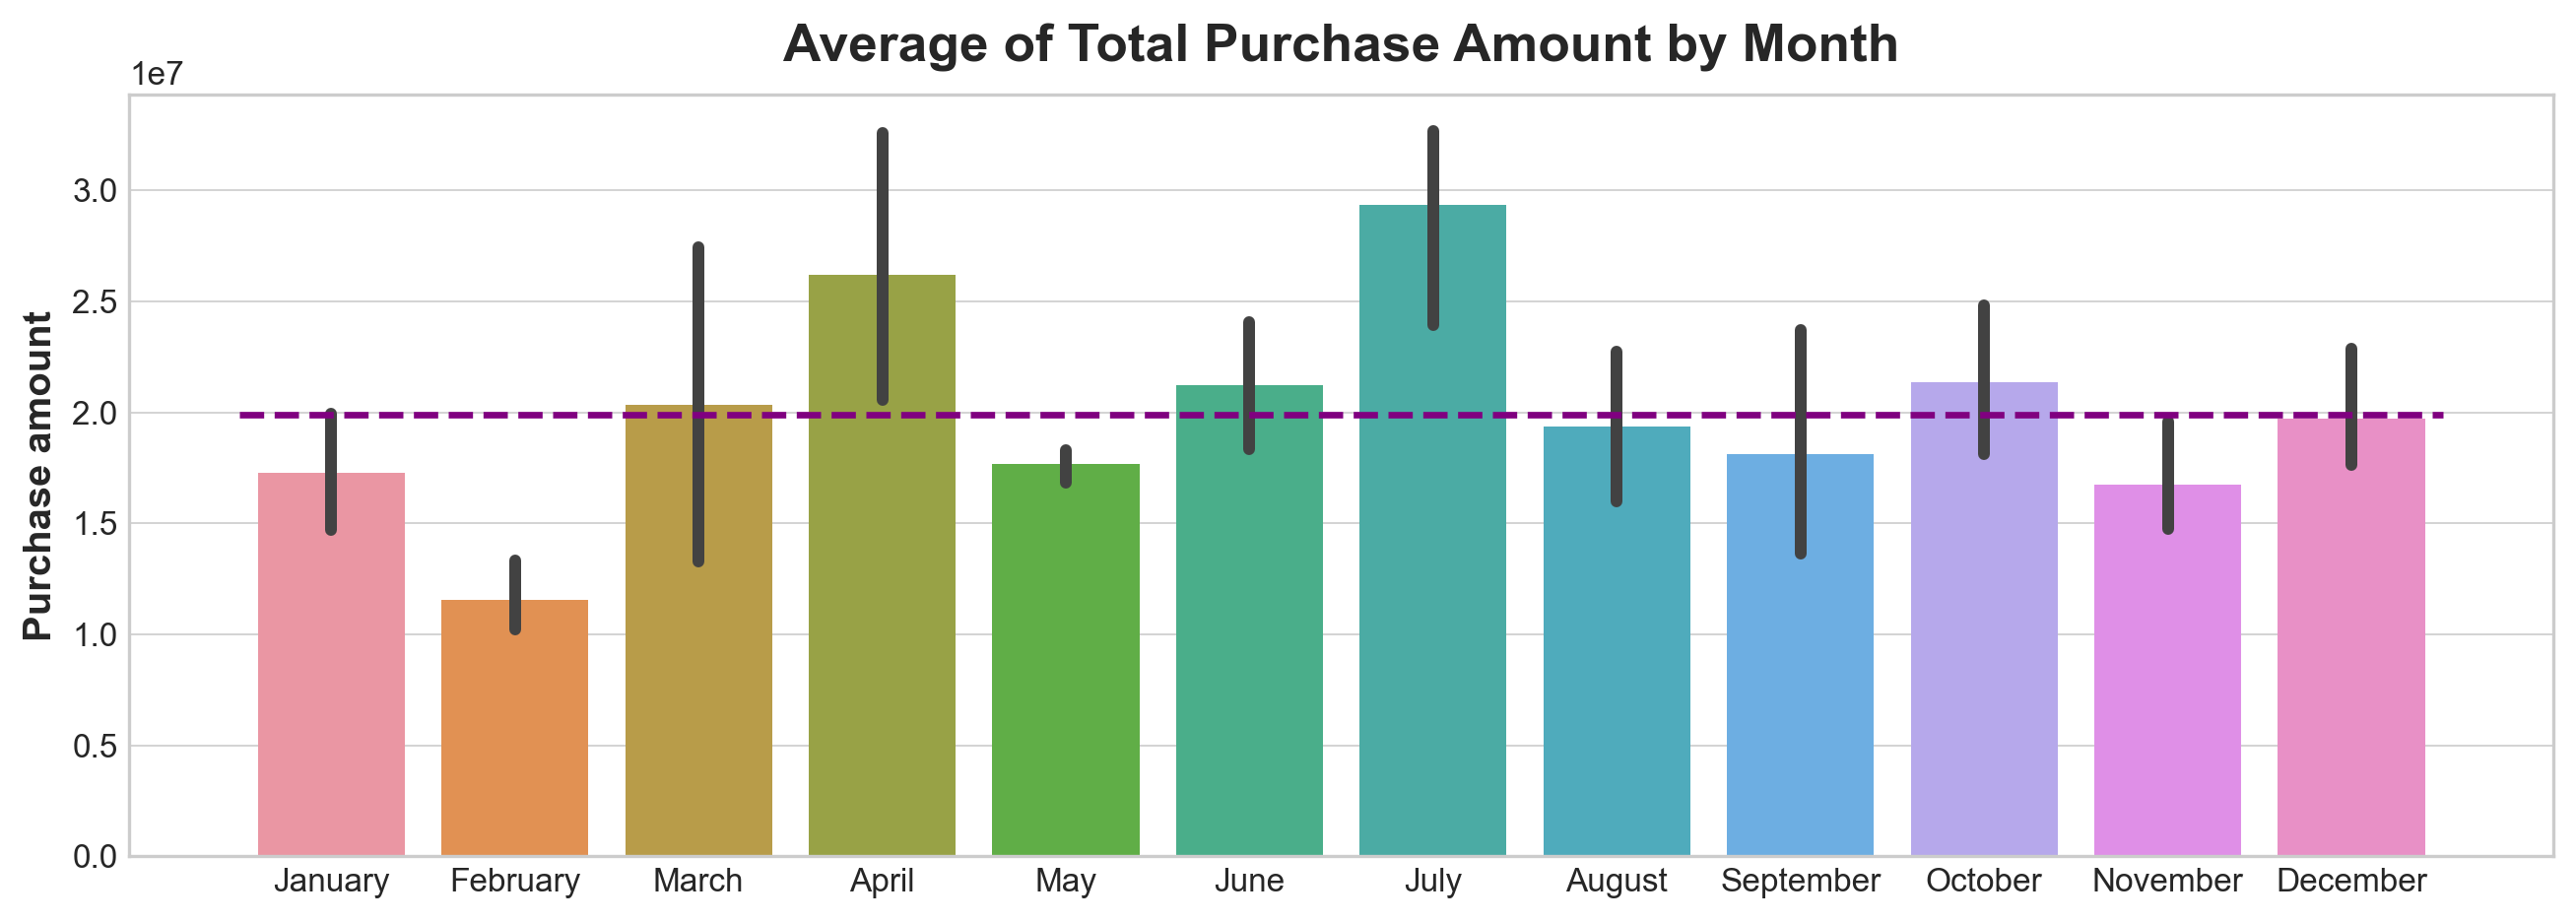

In [21]:
# show average sales per month
ex.q2_viz()

It seems that July has the largest average purchase amount and February has the lowest average purchase amount.

__One sample T-test to check if the average sales per month differ from average monthly sales.__

$H_0$: There is no significant difference in  average of total purchase  per month and average yearly purchase amount.

$H_a$: There is a significant difference in  average of total purchase  per month and average yearly purchase amount.

In [22]:
# run statistical test for every month
ex.q2_ttest()

,T-value,P-value
Month,,
July,3.63,0.04
April,1.66,0.19
October,0.74,0.51
June,0.71,0.53
March,0.10,0.92
December,-0.12,0.91
August,-0.27,0.80
September,-0.59,0.60
January,-1.80,0.17


#### Takaways:
- The highest purchase amount are happening in July, followed by April, October and June.
- The lowest sales happen on February.
- March has almost the same results as average sales, but there was peak in sales on March, 2020 when pandemic just started, it might happened that March is typically low on sales.
- April results might be affected by beginning of pandemic, too.

### 3. Is there any significant difference in purchase amount  by the quarter?

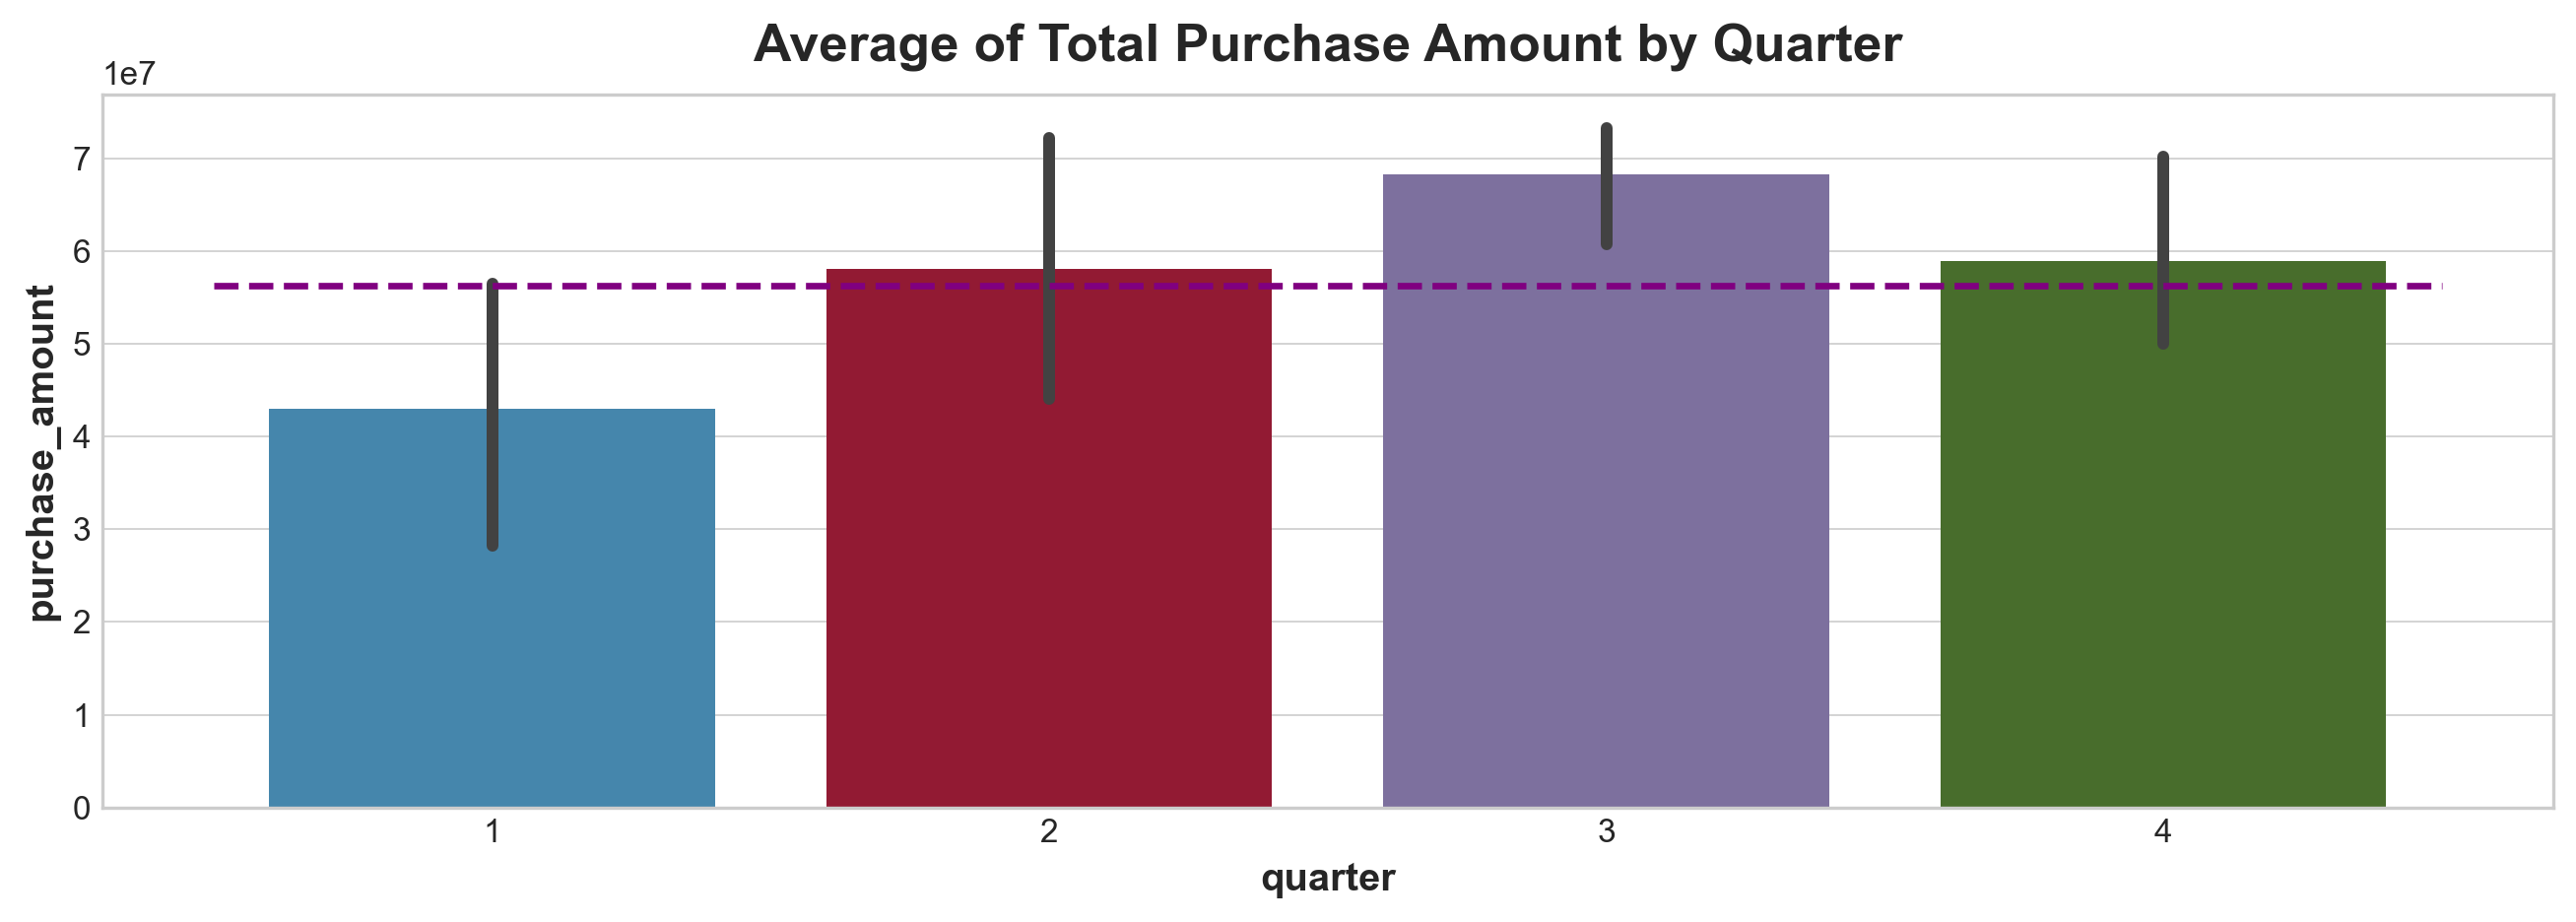

In [23]:
# visualize quarters
ex.q3_viz()

Looks like first and third quarter are significantly different from the quarterly mean of purchase amount. In the first quarter purchase amounts are much lower and in the third quarter they are higher. Let's check this observation with a statistical test. We'll run a sample T-test to compare mean of the sample against the mean of the population.

$H_0$: The quarterly purchase amount of each quarter are not significantly different from overall mean quarterly purchase amount.

$H_a$: The quarterly purchased amount of each quarter are significantly different from overall quarterly purchase amount.

In [24]:
# run t-test
ex.q3_ttest()

,T-value,P-value
Quarter,,
1.00,-1.60,0.19
2.00,0.23,0.84
3.00,3.06,0.06
4.00,0.46,0.68


Despite the obvious difference in the quarterly purchase amount on the bar chart, statistical test disproved this statement. We fail to reject the null hypothesis because the difference in means is not significant.

#### Takeaways:
- Highest sales are in the 3rd quarter.
- Lowest sales are in the 1st quarter.
- Average qurterly sales per each quarter are not significantly different from the overall average quarterly sales.

### 4. Is there any significant change in monthly purchase amount percentage in our data?

Now let's have a closer look into monthly percentage change in total sales. The graph below shows clear spike in total sales in March, 2020, exactly in the beginning of COVID-2019 pandemic.

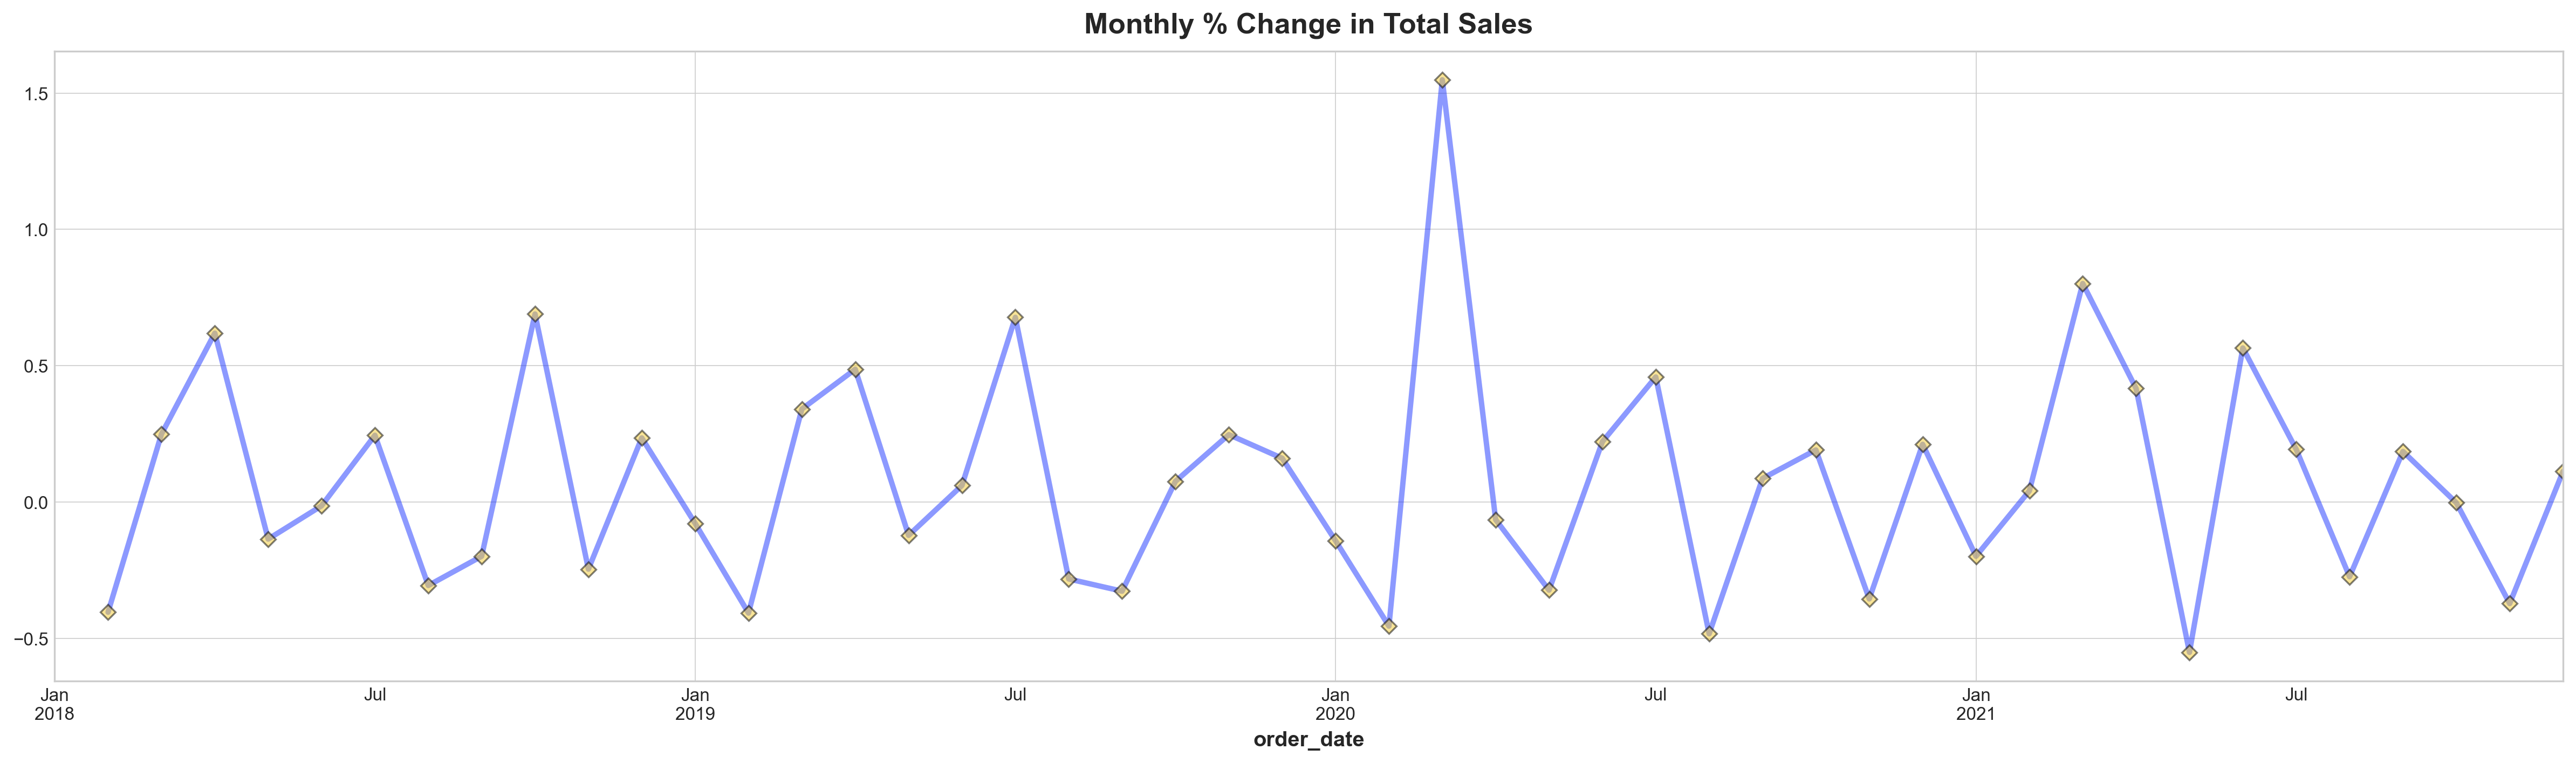

In [25]:
# show monthly % change
ex.q4_viz()

### Takeaway:
In the beginning of the pandemic there was a spike in sales.

### 5. Were there any abnormal purchase orders during the time frame in the data set, if so by who?
- We know that the covid-19 global pandemic altered business in the United States among countries of the world. Certainly Cisco Systems' purchase amount in the state of Texas would be effected somehow. We set out to see if there would be large anamolous activities around the year 2020. First, we found that there is an enormous jump in quantities of orders from customers. This jump occured on Janurary 2, 2020. Texas Health and Human Services Commission purchased 3,767,123 units of something and 865,822 units of something else. 

- We found that a large purchase order like this is made for Texas Health and Human Services periodically, but the purchase order is limited to around 1 million. This purchase probably had to do with foresight regarding what could come given the brewing pandemic which was being reported in China.

- You may follow the following graphs to see the findings

__Notice the large order quantity outlier__

Texas Health and Human Services orders.

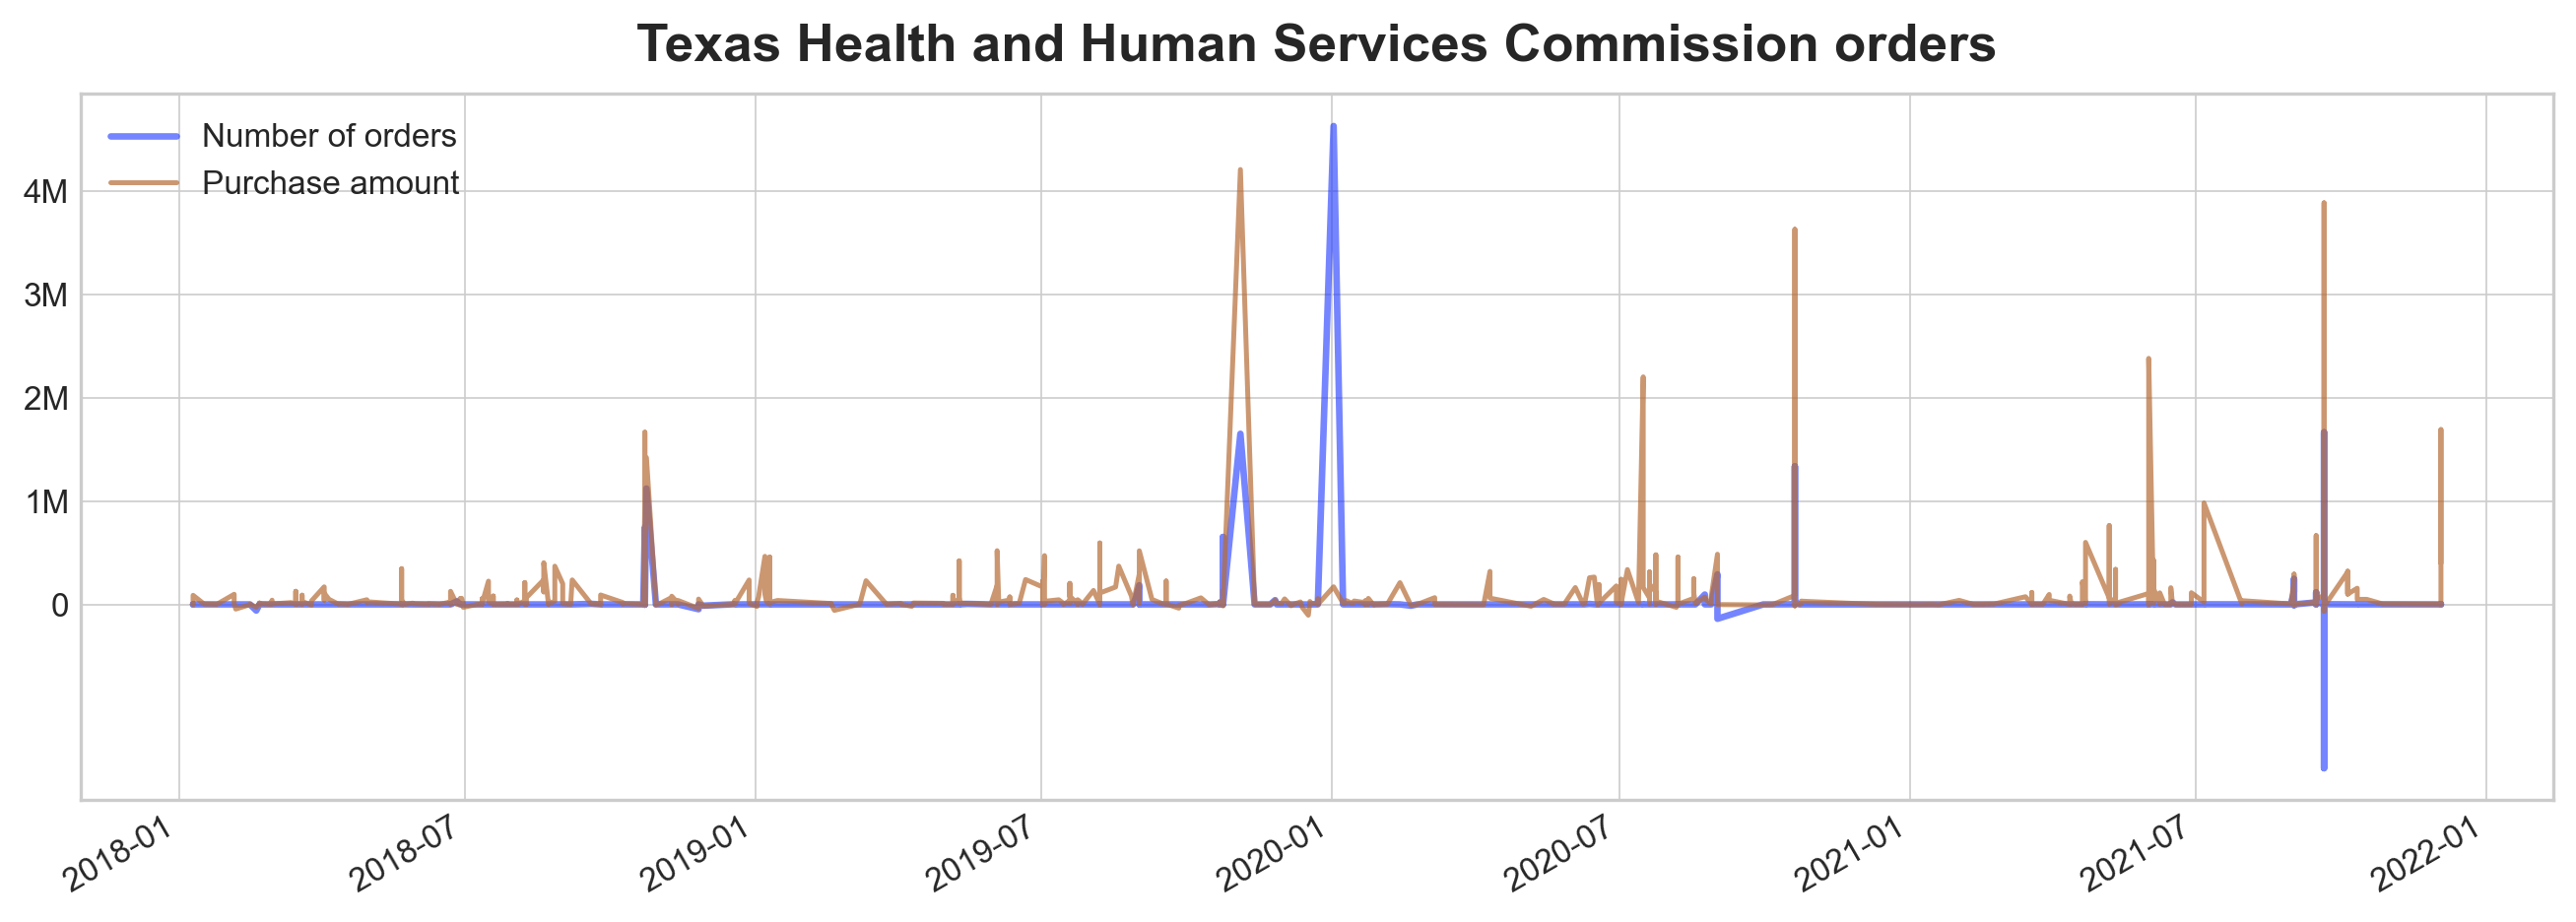

In [26]:
# show the orders and payments history for THHS
ex.q5_thhsc()

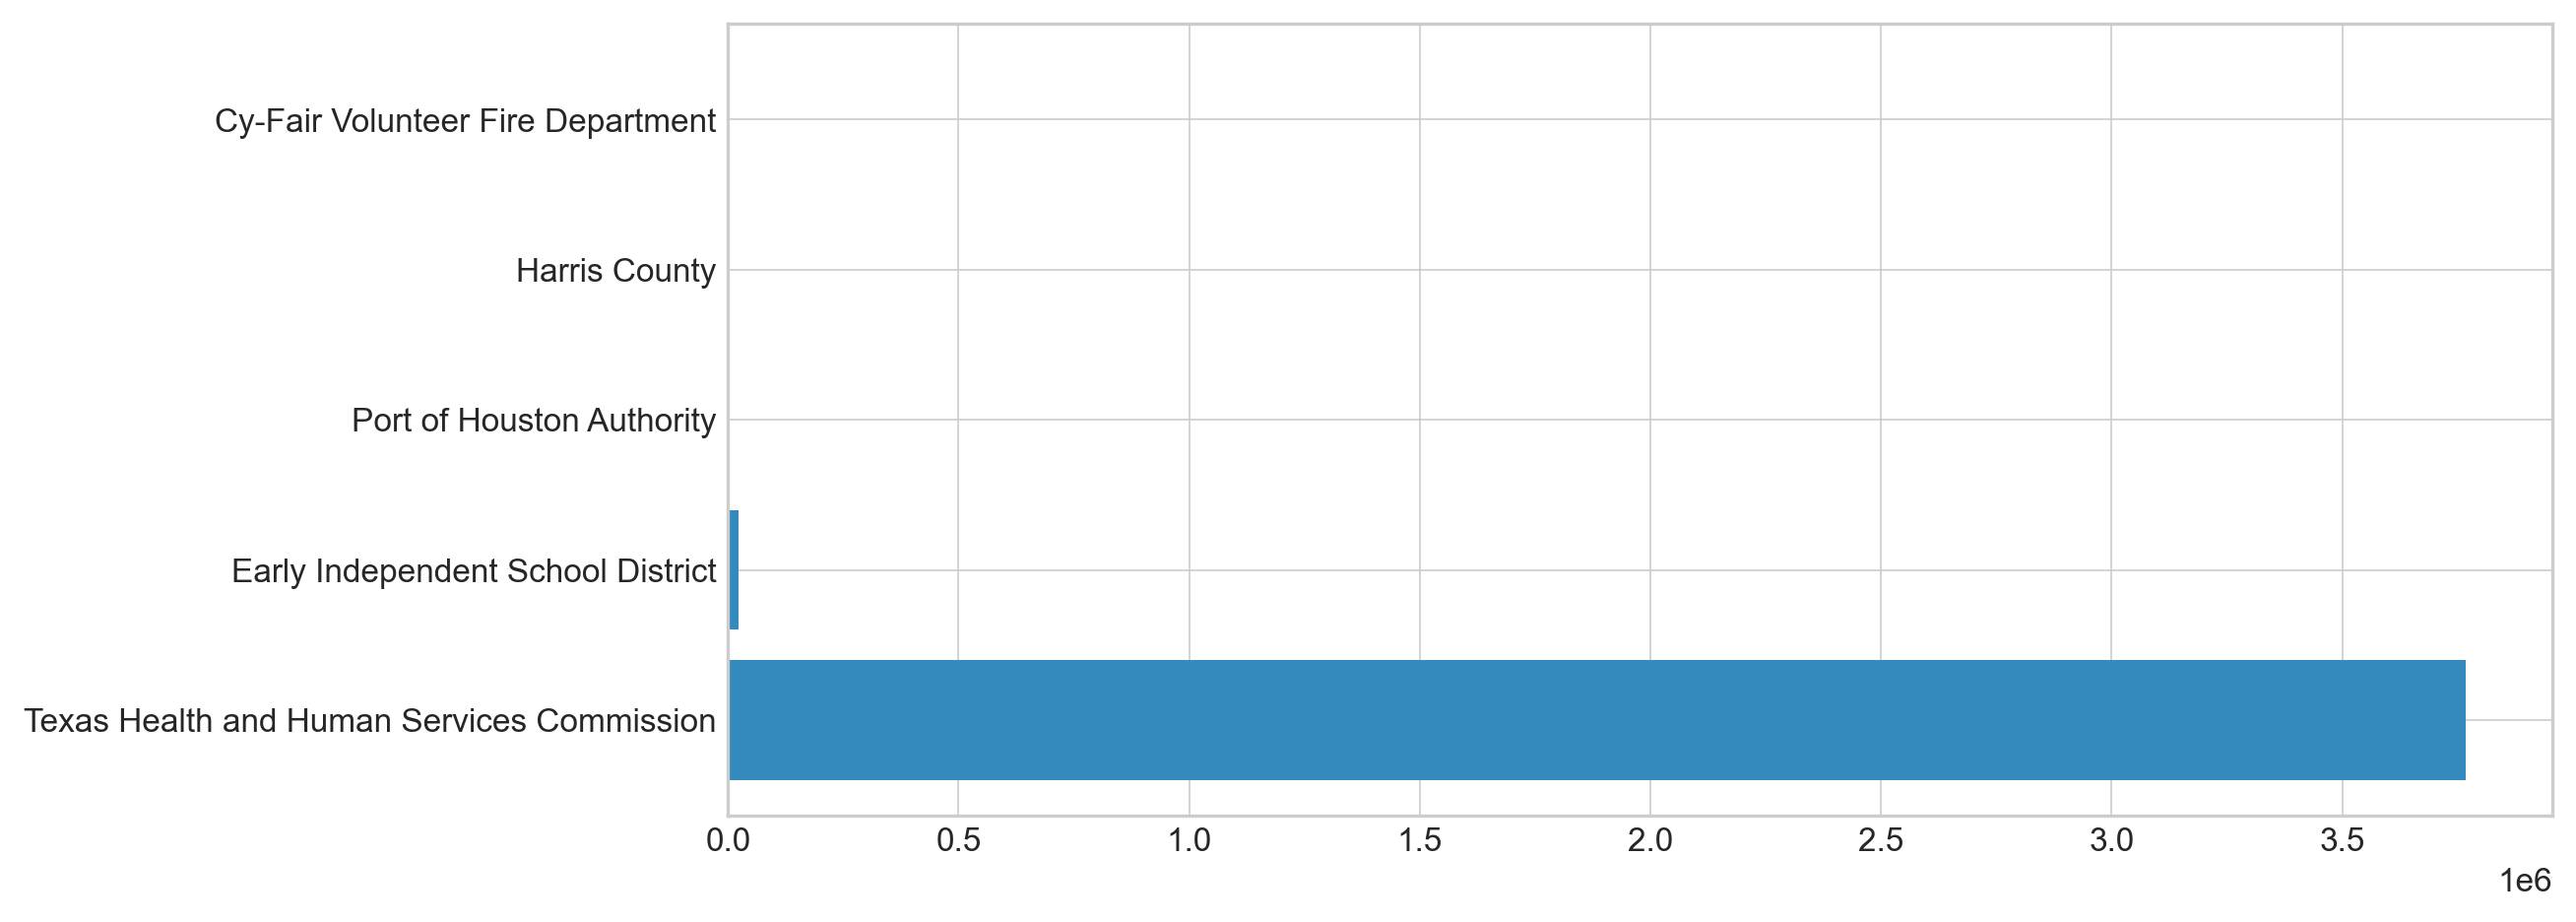

In [27]:
# show the orders on Jan, 2 2020
ex.q5_vizC()

We can see that Texas Health and Human Services Commission purchased close to 4 million somethings from Cisco Systems one time, outside of any predictable pattern

<h3 style="color:#2596be;">Data Exploration Takeaways</h3> 

- Cisco customers represented in DIR data set are divided into following groups:
    * Local Governments - 34.82%
    * Independent School Districts - 31.80 %
    * Higher Education Institutions - 22.54%
    * State Agencies - 10.27%
    * Other public agencies - 0.56%
    
__Daily purchase amounts__
- All purchase amounts per day of the week were significantly different from the average weekly purchase amounts.
- Week days have higher sales than the average and weekend days almost don't have sales.
- Monday, Tuesaday and Wednesday seem to have same average amount of purchase amounts.
- Friday has the highest average purchase amount among all days of the week.

__Monthly purchase amounts__
- The highest purchase amounts are happening in July, followed by April, October and June.
- The lowest purchase amounts happen on February.
- March has almost the same results as average purchase amounts, but there was peak in purchase amounts on March, 2020 when pandemic just started, it might happened that March is typically low on purchase amounts.
- April results might be affected by beginning of pandemic, too.

__Quarterly purchase amounts__
- Highest purchase amounts are in the 3rd quarter.
- Lowest purchase amounts are in the 1st quarter.
- Average qurterly purchase amounts per each quarter are not significantly different from the overall average quarterly purchase amounts.

__Pandemic observations__
- In the beginning of the pandemic there was a spike in purchase amounts.

<h3 style="color:#2596be;">Time Series Modeling</h3> 

To prepare the data set for time series modeling we created the data frame that contains the information only about the sale's date and amount. The `purchase_amount` is the total sale number by the end of the day. At the removed all information about customers and customer types.

In [28]:
from importlib import reload

In [29]:
reload(tsmd)

NameError: name 'tsmd' is not defined

In [30]:
# show first 3 rows of our train data
tsmd.X_train.head(3)

NameError: name 'tsmd' is not defined

We left the train set the same. It includes data till the end of 2021. We split our test set into validate and test sets. The validate set has data January till June, 2022. The test set contains information about sales in time period July - November, 2022.

Let's have a quick look how sales are changing through the time.

In [31]:
# show daily sales visualization
tsmd.show_ts()

NameError: name 'tsmd' is not defined

This graph doesn't give us much hope. We data looks pretty noisy. We can not observe any trend or seasonality that simplify time series predictions. The sales spikes are inconsistent.

### Data evaluation

To evaluate the model performance we going to use __RMSE score__. This score calculates the absolute error. The lower is RMSE score, the better is model performance. The RMSE score should not be higher than the baseline's model score. __The baseline model__ is the model where all values are the same. In our case it is the average daily sale amount. We going to evaluate our model on the validate set to see if it has good predicting power.

In [32]:
# show the baseline value
tsmd.baseline

NameError: name 'tsmd' is not defined

In [33]:
# evaluate and plot baseline
tsmd.evaluate()

NameError: name 'tsmd' is not defined

Because we don't observe any trend in our data we can not use Holt's Linear Trend models. We decided to try ARIMA models, that rely on moving average and stationarity of the data. The results of ARIMA models you can see below.

In [34]:
# create ARIMA models and show their scores
tsmd.create_arima_models()

NameError: name 'tsmd' is not defined

The first three models beat baseline score but just by a little bit, and they definately are not good.

The next step we took is building regression model with XGBoost Regressor. 

In [35]:
# create XGBoost model
tsmd.run_xgboost()

NameError: name 'tsmd' is not defined

XGBosst Regressor model beats the baseline's RMSE score and outperformes all other models that we've created. We are going to use XGBoost Regressor for our test data set.

In [36]:
# show scores and predictions of the test set
tsmd.run_test_model()

NameError: name 'tsmd' is not defined

#### Modeling summary

- Our model beats a baseline on all train, validation and test sets. Anyway, there is much more work to do. We'd like to improve results by making weekly/monthly resamples hoping find some seasonality. We'd like to remove the some pandemic sales anomalies as well. If this won't improve model performance, our next step is going to be splitting data on 5 different sets based on the customer type and make predictions for every set.

<h3 style="color:#2596be;">Conclusions and next steps</h3> 

The goals of this project were:
- Explore the historical data of the DIR contracts with Cisco. 
- Create a model for the sales forecast of Cisco with public agencies.

Our model performs better than a baseline model but needs some improvents.

As the next step for this project we'd like to:
- create weekly/monthly resamples hoping find some seasonality and trends
- remove the some pandemic sales anomalies as well

or, as final step
- split data on 5 different sets based on the customer type and mae predictions for every set.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# project modules
import src.wrangle as wr
import src.explore as ex
import src.summaries as s
import src.ts_models_d as tsmd
import src.decomposition as d
import statsmodels.api as sm
from importlib import reload

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# makes vizualizations better in a jupyter notebook
%config InlineBackend.figure_format = 'retina'

In [38]:
start2018_ = wr.get_start2018()
# declaring global variables
df = s.get_summary_df(wr.get_clean_data(start2018=False))
df = wr.drop2017_and_move2016_up(df)
train, _ = wr.split_data(df)
# show df from 2018 for negative higher education trend
df2018 = s.get_summary_df(wr.get_clean_data(start2018=True))
train2018, _ = wr.split_data(df2018)

y_daily = train.purchase_amount.resample('D').sum()
y_weekly = train.purchase_amount.resample('W').sum()
y_monthly = train.purchase_amount.resample('M').sum()

k_12, local_gov, state_agency, higher_ed, other = wr.create_customertype_subgroups(train)

_, _, _, higher_ed2018, _ = wr.create_customertype_subgroups(train2018)

In [39]:
# create decompositions
# daily decompostions for all types
result_d = sm.tsa.seasonal_decompose(y_daily)
decomposition_d = pd.DataFrame({
    'y': result_d.observed,
    'trend': result_d.trend,
    'seasonal': result_d.seasonal,
    'resid': result_d.resid,
})

# weekly decompostions for all types
result_w = sm.tsa.seasonal_decompose(y_weekly)
decomposition_w = pd.DataFrame({
    'y': result_w.observed,
    'trend': result_w.trend,
    'seasonal': result_w.seasonal,
    'resid': result_w.resid,
})

# mothly decomposition for all types
result_m = sm.tsa.seasonal_decompose(y_monthly)
decomposition_m = pd.DataFrame({
    'y': result_m.observed,
    'trend': result_m.trend,
    'seasonal': result_m.seasonal,
    'resid': result_m.resid,
})
decomposition_m['time_dummy'] = np.arange(len(decomposition_m.index))

# monthly decomposition schools
k_12m = k_12.purchase_amount.resample('M').sum()
result_k_12m = sm.tsa.seasonal_decompose(k_12m)
decomposition_k_12m = pd.DataFrame({
    'y': result_k_12m.observed,
    'trend': result_k_12m.trend,
    'seasonal': result_k_12m.seasonal,
    'resid': result_k_12m.resid,
})
# monthly decomposition schools before 2018
k_12_before = k_12.loc[:'2020']
k_12m_before = k_12_before.purchase_amount.resample('M').sum()
result_k_12m_before = sm.tsa.seasonal_decompose(k_12m_before)
decomposition_k_12m_before = pd.DataFrame({
    'y': result_k_12m_before.observed,
    'trend': result_k_12m_before.trend,
    'seasonal': result_k_12m_before.seasonal,
    'resid': result_k_12m_before.resid,
})

# monthly decomposition higher education
higher_ed_m = higher_ed.purchase_amount.resample('M').sum()
result_higher_ed_m = sm.tsa.seasonal_decompose(higher_ed_m)
decomposition_higher_ed_m = pd.DataFrame({
    'y': result_higher_ed_m.observed,
    'trend': result_higher_ed_m.trend,
    'seasonal': result_higher_ed_m.seasonal,
    'resid': result_higher_ed_m.resid,
})

# monthly decomposition higher education since 2018
higher_ed_m2018 = higher_ed2018.purchase_amount.resample('M').sum()
result_higher_ed_m2018 = sm.tsa.seasonal_decompose(higher_ed_m2018)
decomposition_higher_ed_m2018 = pd.DataFrame({
    'y': result_higher_ed_m2018.observed,
    'trend': result_higher_ed_m2018.trend,
    'seasonal': result_higher_ed_m2018.seasonal,
    'resid': result_higher_ed_m2018.resid,
})

# monthly decomposition local governments
local_gov_m = local_gov.purchase_amount.resample('M').sum()
result_local_gov_m = sm.tsa.seasonal_decompose(local_gov_m)
decomposition_local_gov_m = pd.DataFrame({
    'y': result_local_gov_m.observed,
    'trend': result_local_gov_m.trend,
    'seasonal': result_local_gov_m.seasonal,
    'resid': result_local_gov_m.resid,
})

# monthly decomposition state agencies
state_agency_m = state_agency.purchase_amount.resample('M').sum()
result_state_agency_m = sm.tsa.seasonal_decompose(local_gov_m)
decomposition_state_agency_m = pd.DataFrame({
    'y': result_state_agency_m.observed,
    'trend': result_state_agency_m.trend,
    'seasonal': result_state_agency_m.seasonal,
    'resid': result_state_agency_m.resid,
})



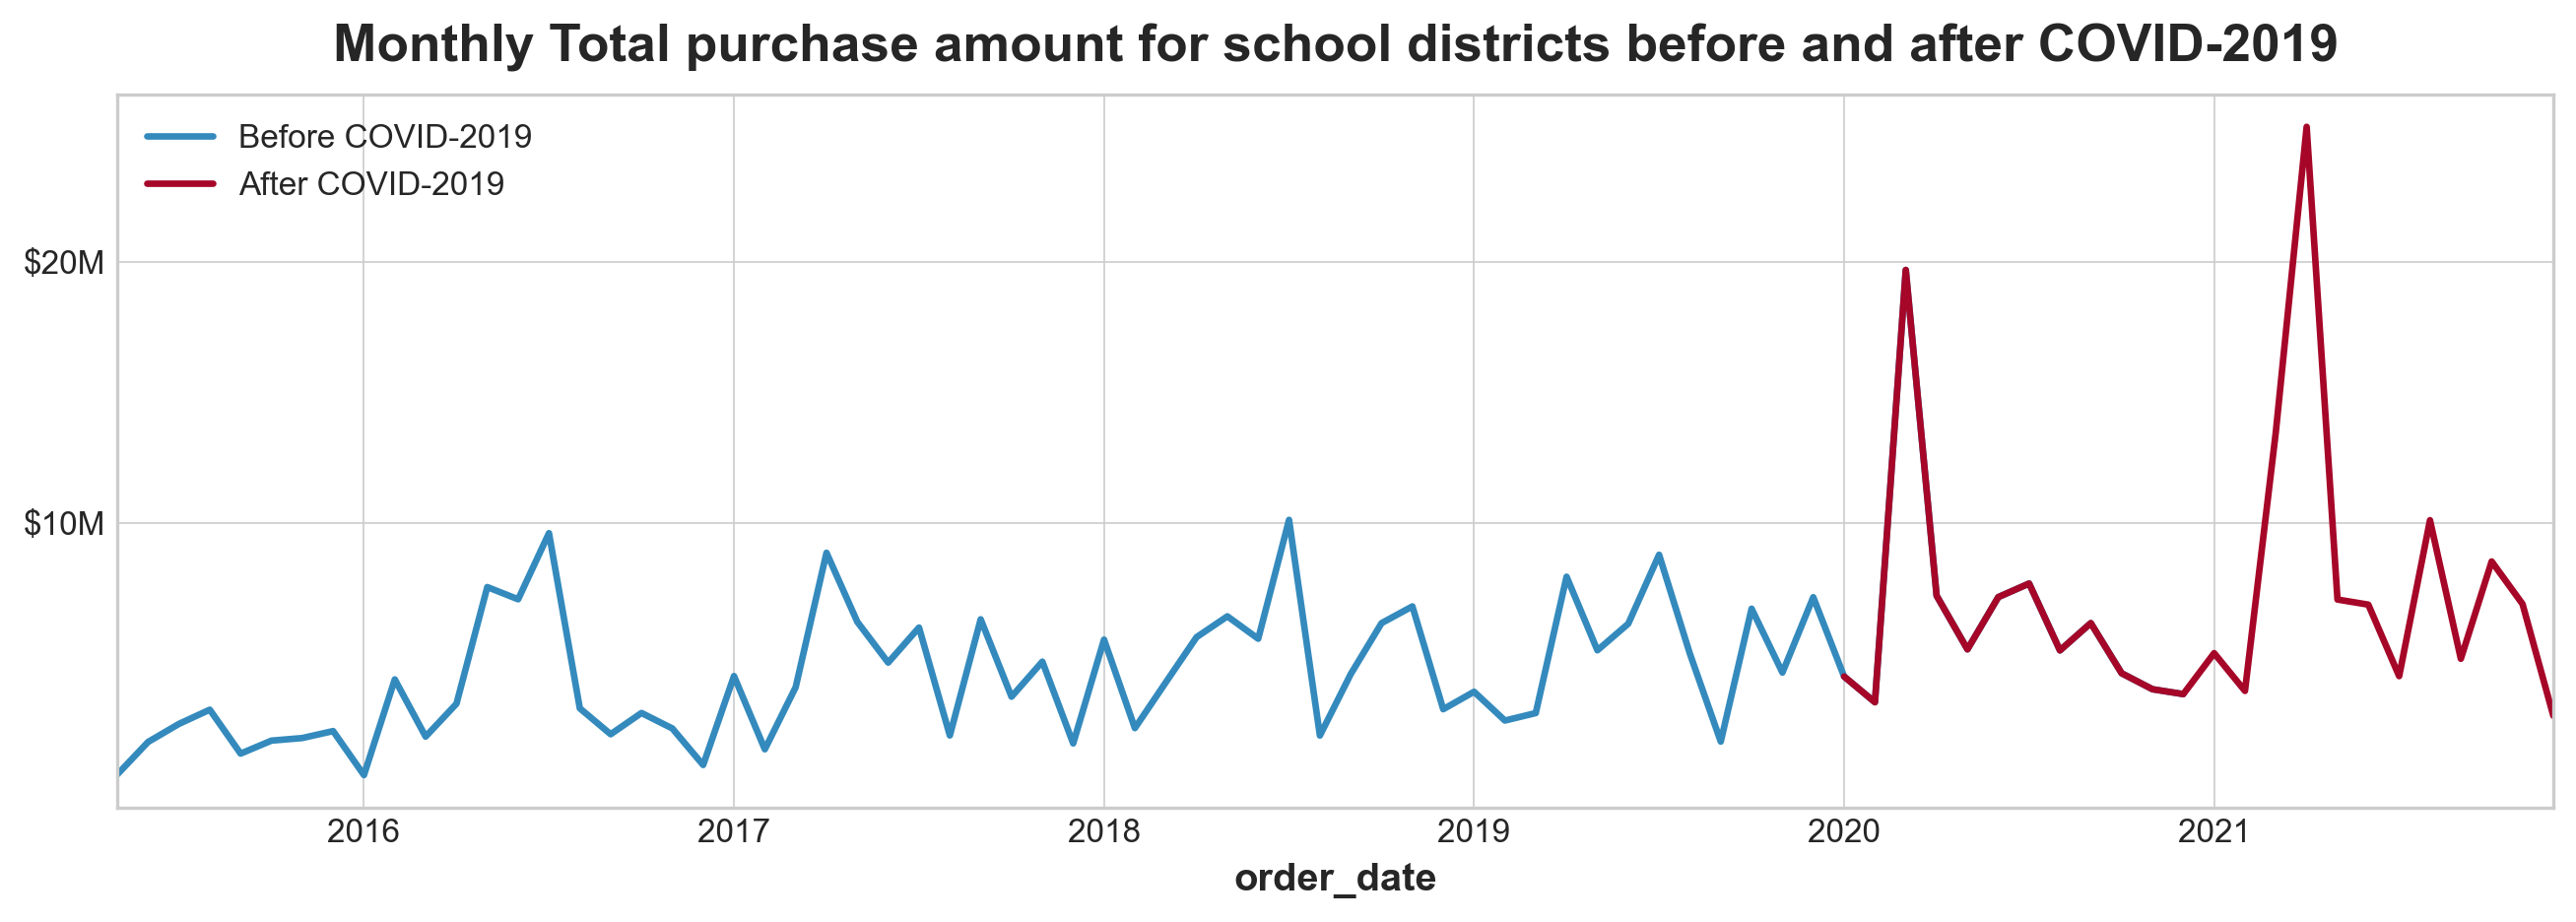

In [40]:
def viz_school_purchases():
    '''
    Creates a plot with 
    '''
    ax = k_12m.loc[:'2020'].plot(label='Before COVID-2019', lw=2)
    ax = k_12m.loc['2020':].plot(label='After COVID-2019', lw=2)
    plt.title('Monthly Total purchase amount for school districts before and after COVID-2019')
    ax.set(yticks=[10_000_000, 20_000_000])
    ax.set(yticklabels=['$10M', '$20M'])
    plt.legend()
    plt.show()
viz_school_purchases()

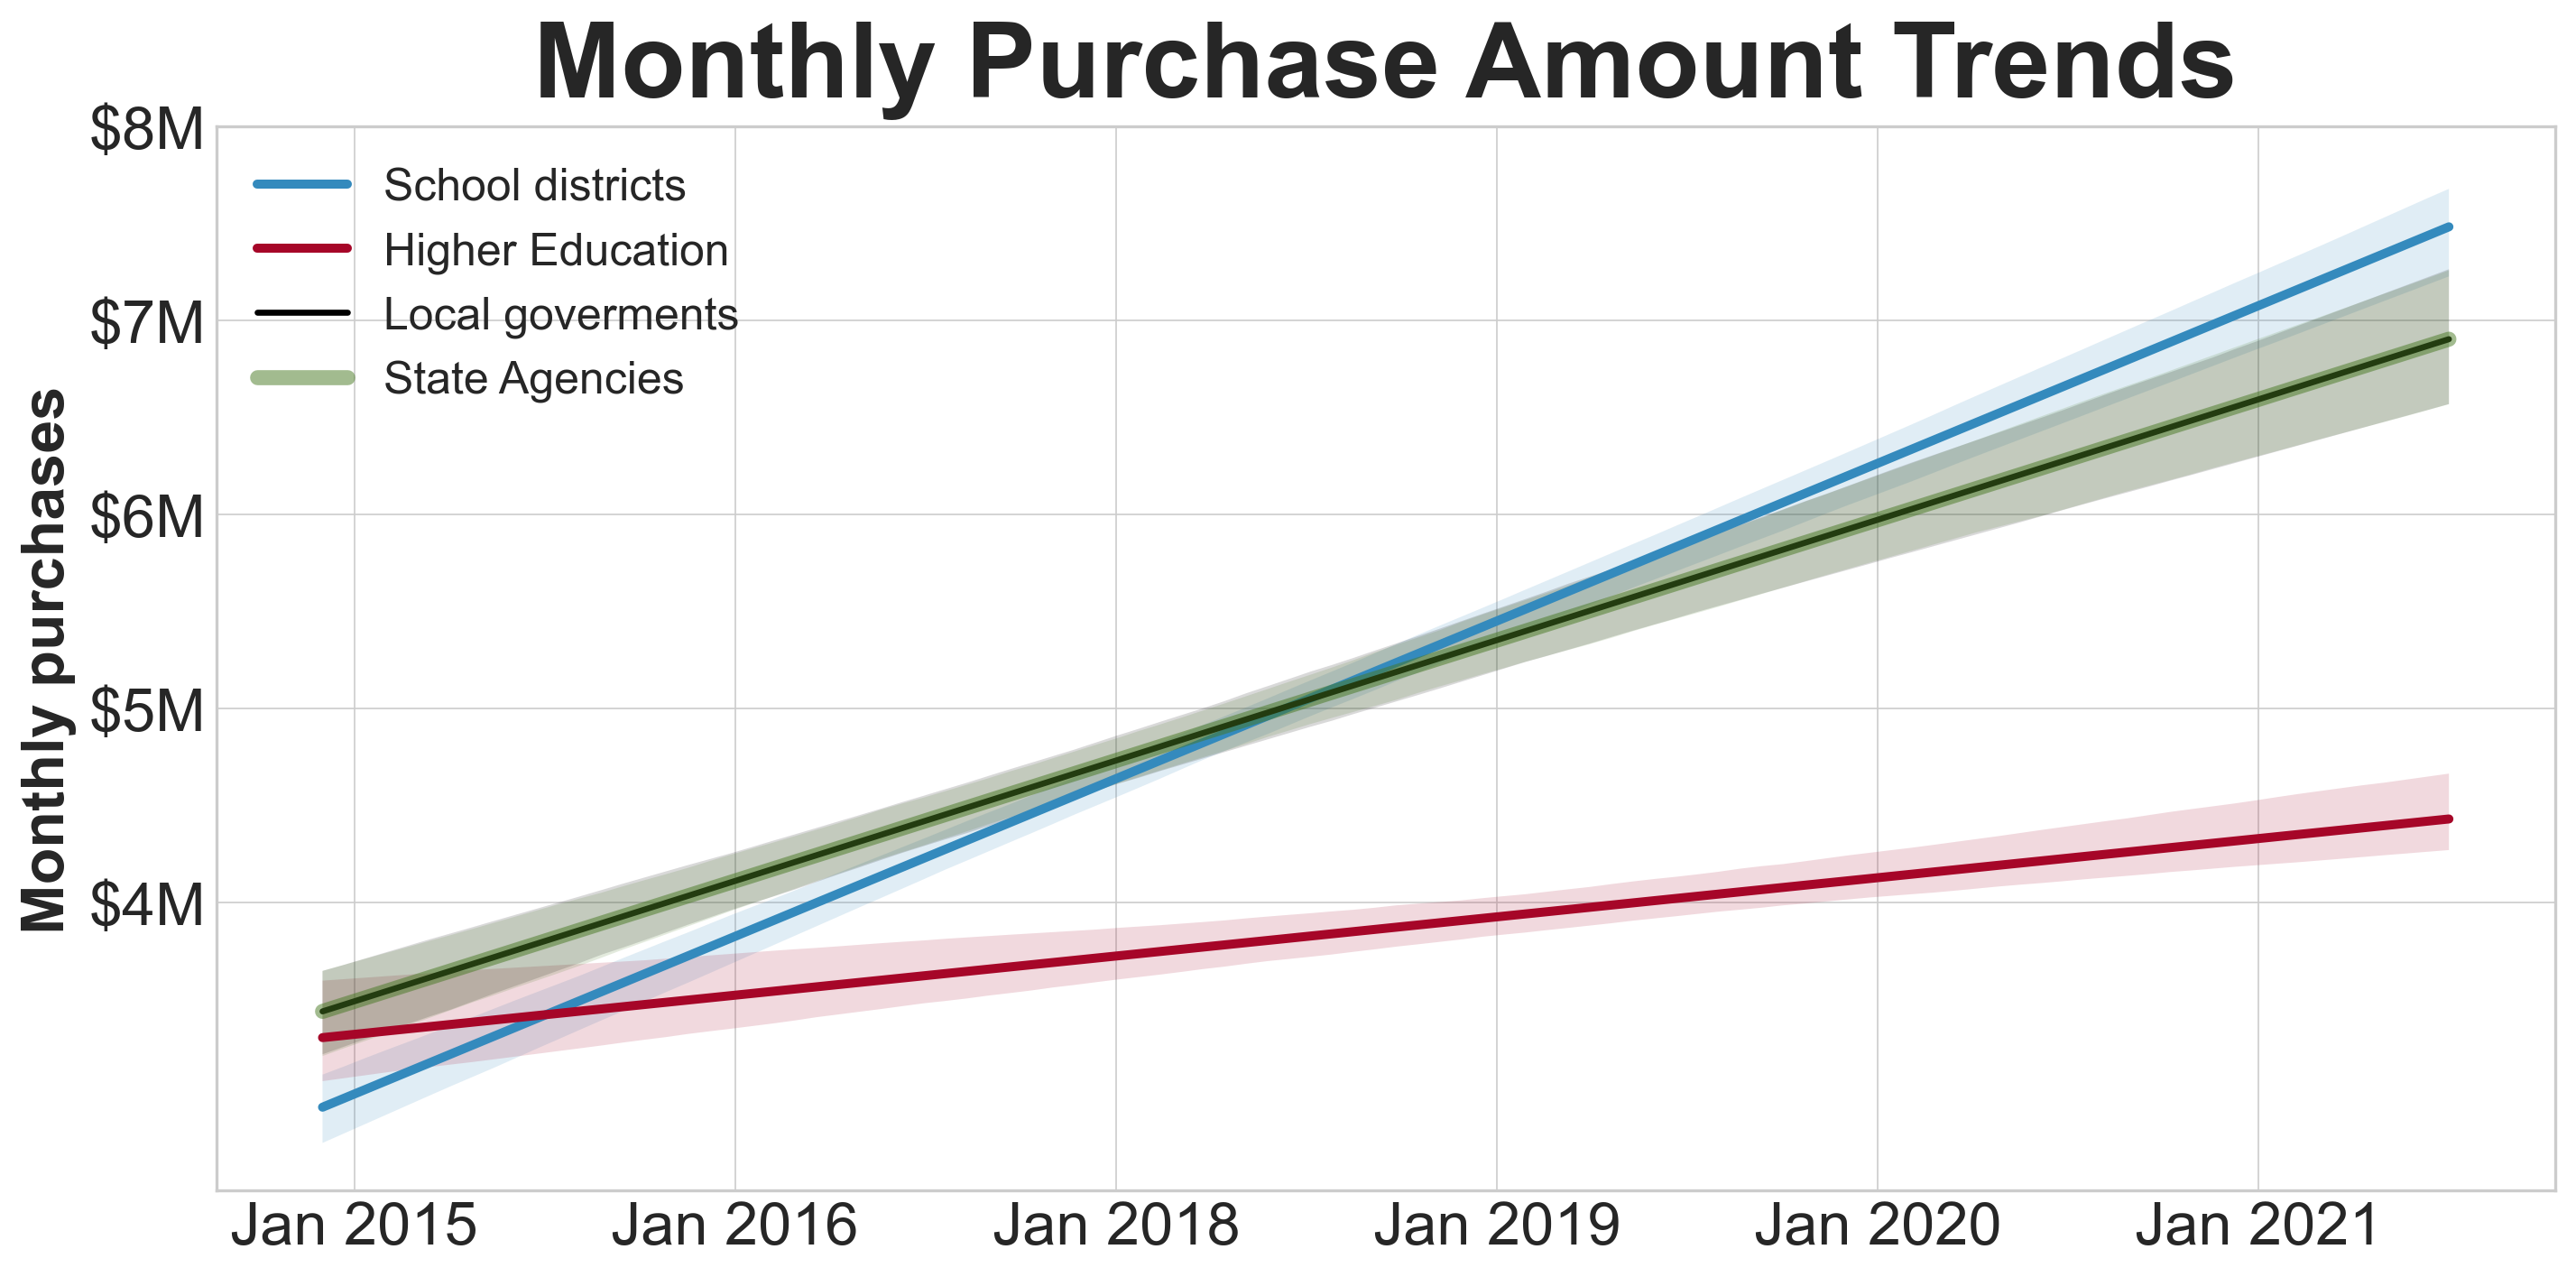

In [91]:
def show_all_trends():
    '''
    show monthly trends for all customer types except 'others'
    '''
    plt.figure(figsize = (12,6))
    k12_trend = decomposition_k_12m.trend
    hedu_trend = decomposition_higher_ed_m.trend
    loc_gov_trend = decomposition_local_gov_m.trend
    state_agency_trend = decomposition_state_agency_m.trend
    
    overall_trend = decomposition_m.trend
    # create time dummies
    time_dummy = decomposition_m.time_dummy
    ax = sns.regplot(x=time_dummy, y=k12_trend, scatter=False, label='School districts')
    ax = sns.regplot(x=time_dummy, y=hedu_trend, scatter=False, label='Higher Education')
    ax = sns.regplot(x=time_dummy, y=loc_gov_trend, scatter=False, label='Local goverments', line_kws={'alpha':1,'color':'Black', "linewidth":2})
    ax = sns.regplot(x=time_dummy, y=state_agency_trend, scatter=False, label='State Agencies',line_kws={'alpha':.5,"linewidth":5})


    ax.set(xticks=[7, 19, 31, 43, 55, 67])
    ax.set(xticklabels=['Jan 2015', 'Jan 2016', 'Jan 2018', 'Jan 2019', 'Jan 2020', 'Jan 2021'])
    plt.xlabel(None)
    ax.set(yticks=[4_000_000, 5_000_000, 6_000_000, 7_000_000, 8_000_000])
    ax.set(yticklabels=['$4M', '$5M', '$6M', '$7M', '$8M'])
    plt.ylabel('Monthly purchases',fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=15)
    plt.title('Monthly Purchase Amount Trends',fontsize=35)
    plt.xticks(fontsize=20)
    plt.show()
show_all_trends()

In [42]:
cmap = matplotlib.cm.Blues
mini=min(ct_df.customer_type)
maxi=max(ct_df.customer_type)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in ct_df.customer_type]


Try1:
data = titanic.groupby("deck").size()  # data underlying bar plot in question

pal = sns.color_palette("Greens_d", len(data))
rank = data.argsort().argsort()  # http://stackoverflow.com/a/6266510/1628638
sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1])[rank])

Try3:
```python
    
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)


x = np.arange(10)
y = np.random.random(10)
sns.barplot(x, y, palette=colors_from_values(y, "YlOrRd"))
```


In [43]:

def colors_from_values(values: pd.Series, palette_name:str, ascending=True):
    '''Returns a seaborn palette reordered by value
    Parameters:
    values: pd.Series
    palette_name:str, Seaborn valid palette name
    ascending: bool, optional color sort order
    '''
    # convert to indices
    values = values.sort_values(ascending=ascending).reset_index()
    indices = values.sort_values(by=values.columns[0]).index
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [44]:
data

NameError: name 'data' is not defined

Try2:
cols = ['grey' if (x < max(df.sales)) else 'orange' for x in df.sales]

In [ ]:
import matplotlib.ticker as ticker


cols = ['steelblue' ,'lightskyblue' ,'steelblue' ,'steelblue' ,'steelblue' ,'steelblue'  ,
        'deepskyblue','steelblue' ,'steelblue' ,'steelblue' ,'steelblue' ,'steelblue' ]

# create a df with total purchase amount of the month
train_m = train.purchase_amount.resample('M').sum().to_frame()
# add month name
train_m['month_name'] = train_m.index.month_name()
def q4_viz():
    plt.figure(figsize = (16,5))
    # visualize 
    months =['January', 'February', 'March', 'April', 'May', 
             'June', 'July', 'August', 'September', 'October', 'November', 'December']
    ax = sns.barplot(data=train_m, x='month_name', y='purchase_amount',palette=cols,
                     order=months, ci=False,edgecolor='mintcream',linewidth=2)
    plt.xlabel('')
    plt.ylabel('Purchase Amount', fontsize =20)
    x_left, x_right = ax.get_xlim()
    ax.hlines(train_m.purchase_amount.mean(), x_left, x_right, ls='--', color='purple')
    plt.title('Average of Total Purchase Amount by Month',fontsize=35)
    ax.set(xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 
             'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    plt.legend(fontsize=20)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())  
    plt.show();
q4_viz()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


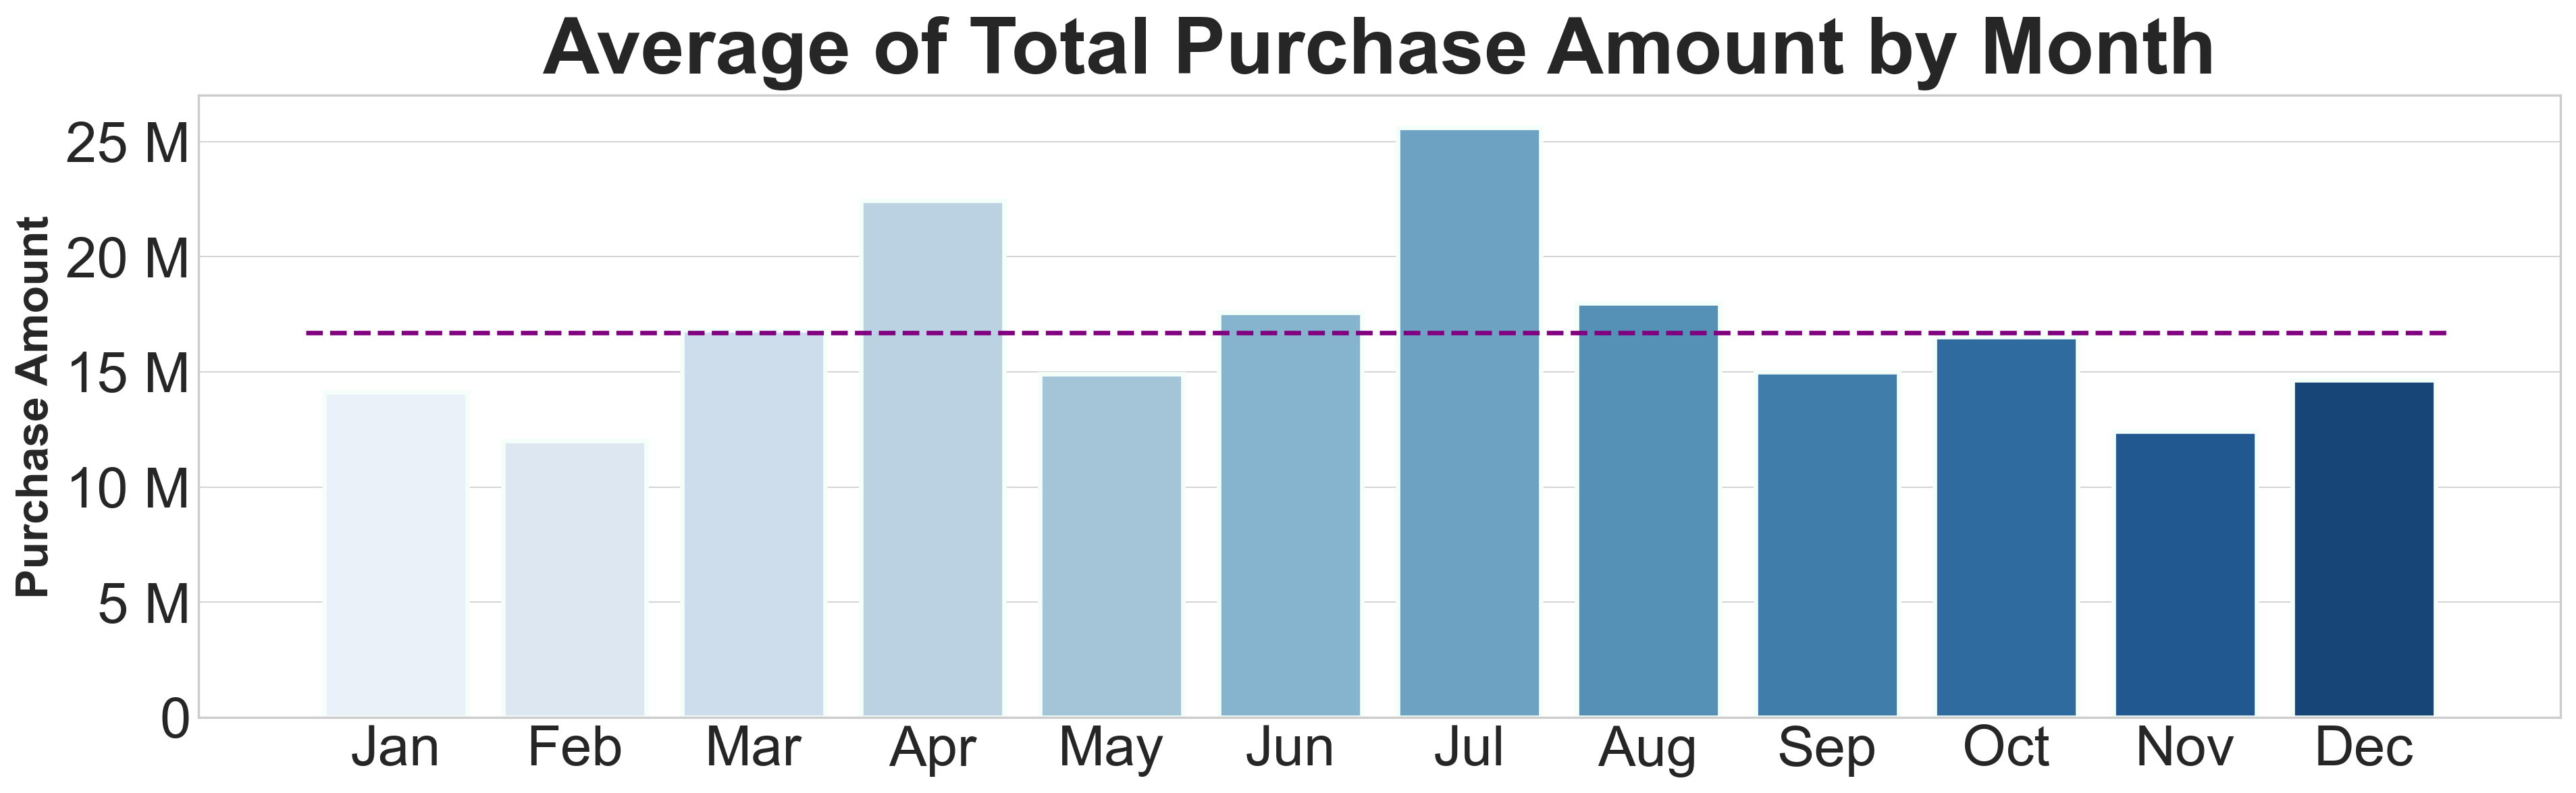

In [45]:
import matplotlib.ticker as ticker

# create a df with total purchase amount of the month
train_m = train.purchase_amount.resample('M').sum().to_frame()
# add month name
train_m['month_name'] = train_m.index.month_name()
def q4_viz():
    plt.figure(figsize = (16,5))
    # visualize 
    months =['January', 'February', 'March', 'April', 'May', 
             'June', 'July', 'August', 'September', 'October', 'November', 'December']
    ax = sns.barplot(data=train_m, x='month_name', y='purchase_amount',palette='Blues',
                     order=months, ci=False,edgecolor='mintcream',linewidth=2)
    plt.xlabel('')
    plt.ylabel('Purchase Amount', fontsize =20)
    x_left, x_right = ax.get_xlim()
    ax.hlines(train_m.purchase_amount.mean(), x_left, x_right, ls='--', color='purple')
    plt.title('Average of Total Purchase Amount by Month',fontsize=35)
    ax.set(xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 
             'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    plt.legend(fontsize=20)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())  
    plt.show();
q4_viz()

In [46]:
df[df.customer_name=="City of San Antonio"].loc['2020-01-30']

customer_name                                    City of San Antonio
customer_type                                       Local Government
customer_city                                            San Antonio
reseller_name      Great South Texas Corporation dba Computer Sol...
shipped_date                                     2020-02-10 00:00:00
year                                                            2020
quarter                                                            1
month                                                              1
week                                                               5
day_of_week                                                        3
day_of_year                                                       30
month_name                                                   January
day_name                                                    Thursday
purchase_amount                                             1,537.78
Name: 2020-01-30 00:00:00, dtype: 

In [47]:
raw_df= wr.basic_clean(raw_df)

NameError: name 'raw_df' is not defined

In [48]:
raw_df[raw_df.customer_name=="City of San Antonio"].loc['2020-01-30']

NameError: name 'raw_df' is not defined

In [49]:
import matplotlib.ticker as ticker

In [50]:
def q1_show_merged_ts():
    '''
    plots daily sales for the X_train
    '''
    #plt.figure(figsize=(12,6))

    # create a temp data frame that will include all data with problematic 2017
    fig, ax = plt.subplots(figsize=(12,6))
    ax = y_weekly.plot(alpha=0.7)
    #plt.title('Daily Purchase Amount After Removing 2017', size=18, weight='bold')
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) 
    #ax.set(yticks=[0, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000, 6_000_000, 7_000_000])
    #ax.set(yticklabels=['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M'])
    ax.set(xticks=['2015', '2016', '2017', '2018', '2019', '2020','2021'])
    ax.set(xticklabels=['2015', '2016', '2017', '2018', '2019', '2020','2021'])
    ax.set_xlim(right=pd.Timestamp("2022-01-30 00:00:00"))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('')
    plt.show()

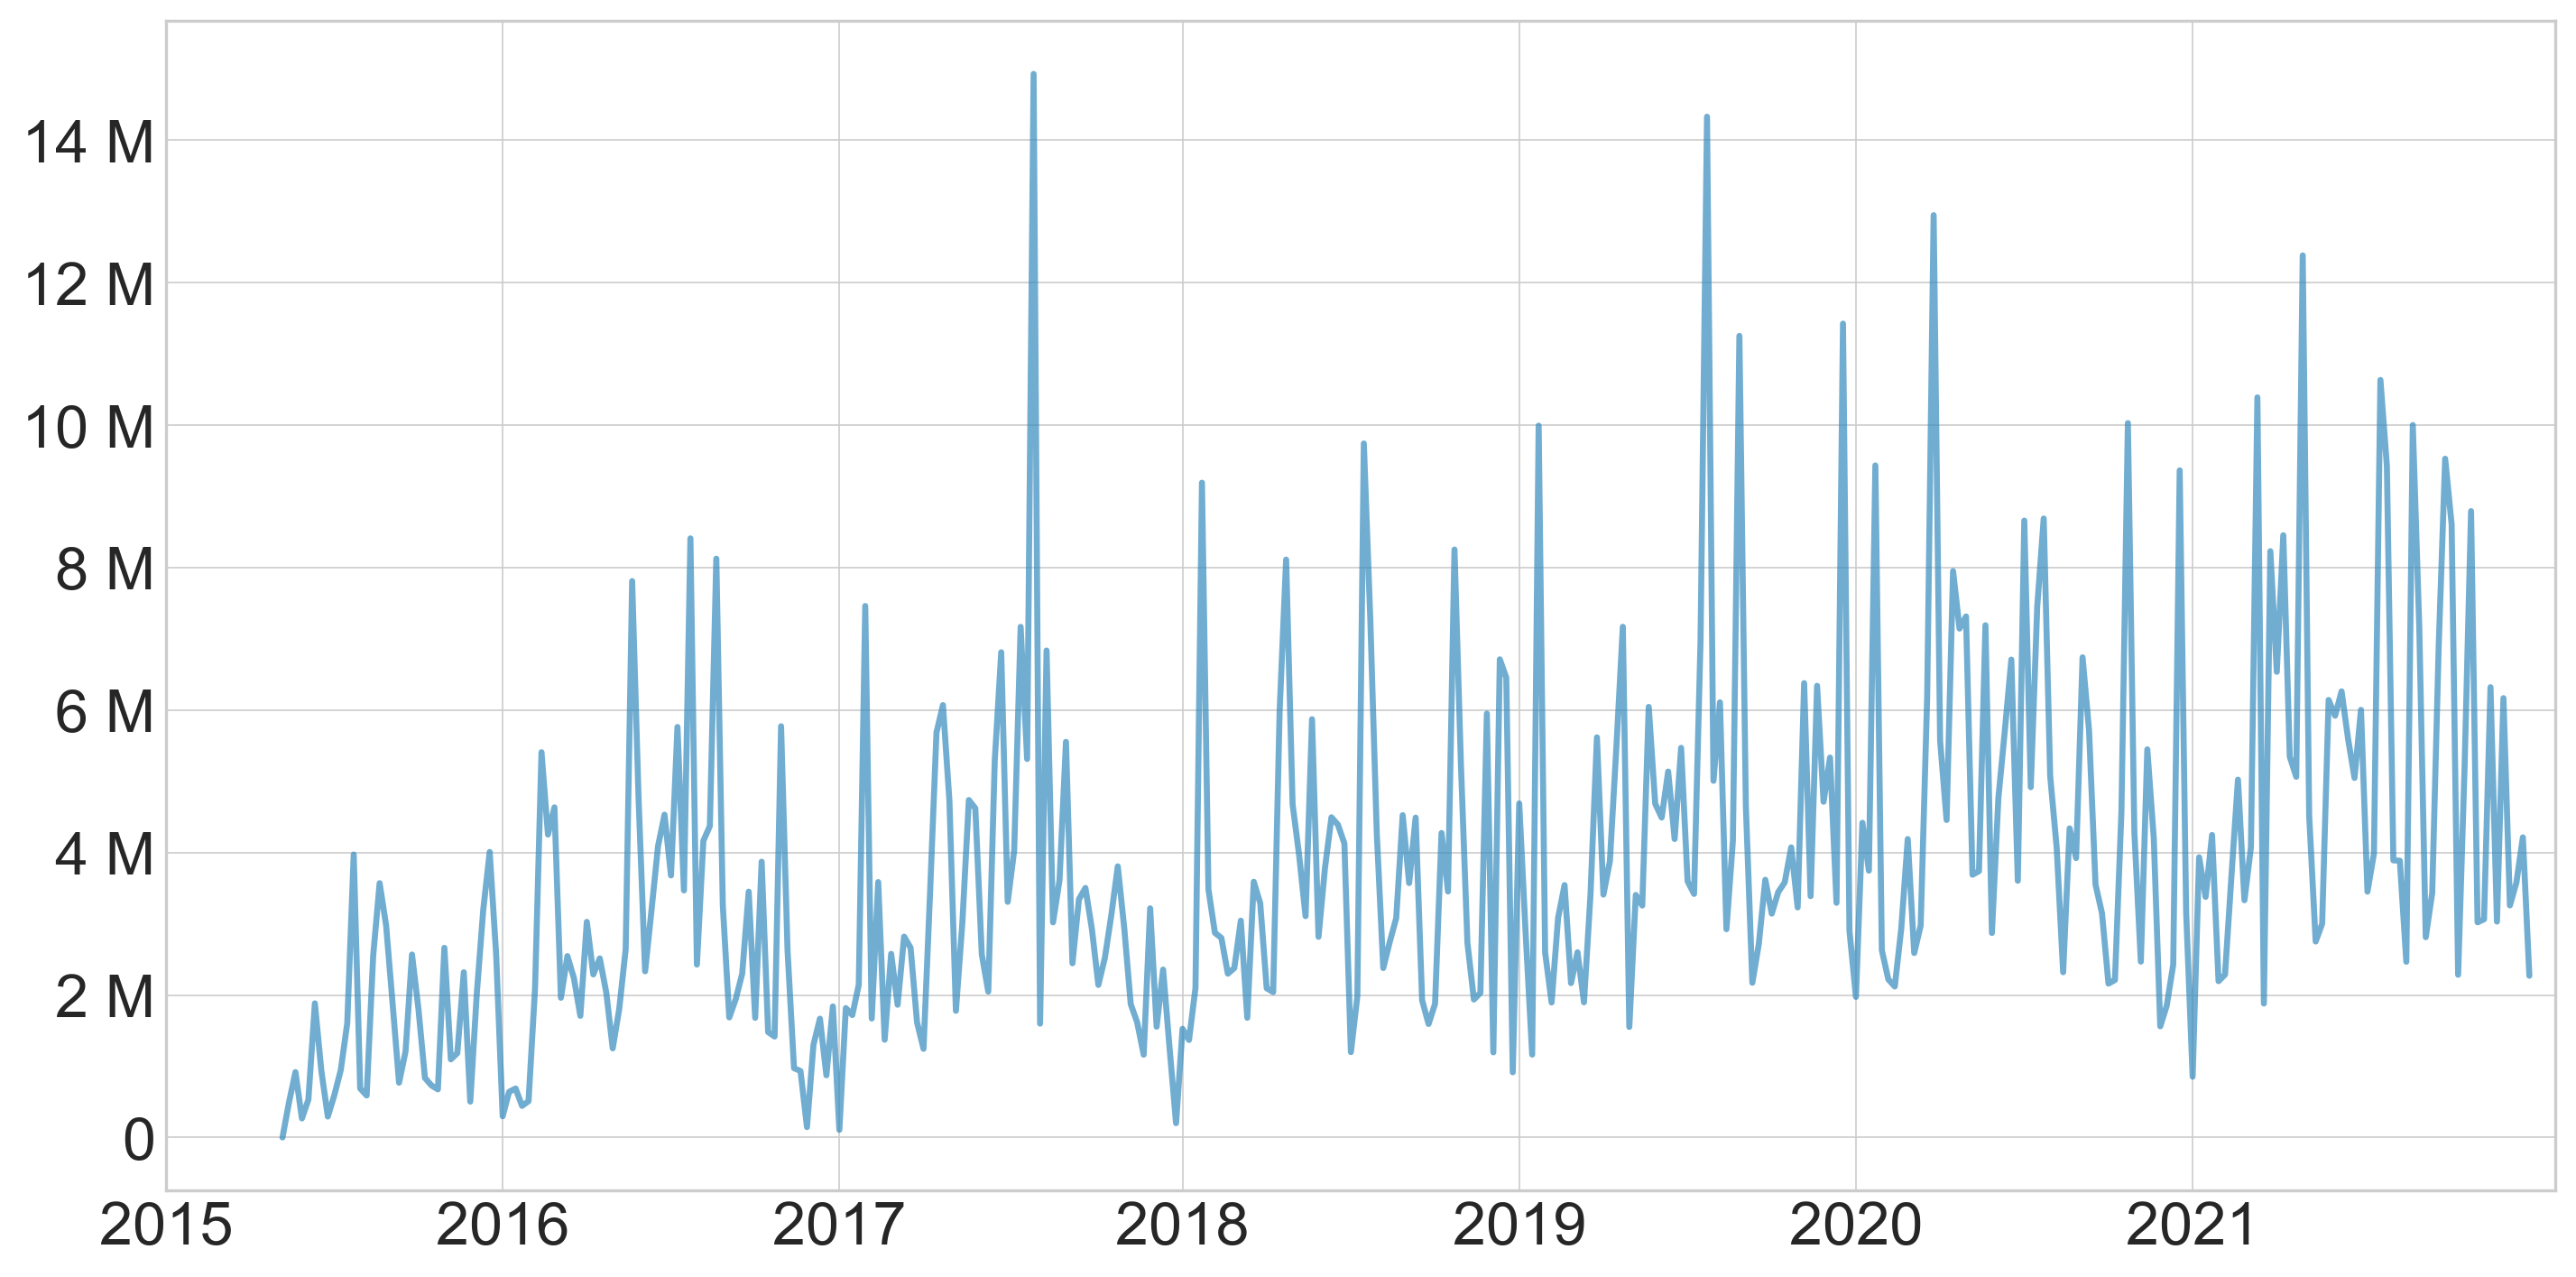

In [51]:
q1_show_merged_ts()

In [52]:
m_daily = miss.purchase_amount.resample('D').sum()
m_weekly = miss.purchase_amount.resample('W').sum()
m_monthly = miss.purchase_amount.resample('M').sum()

NameError: name 'miss' is not defined

NameError: name 'm_weekly' is not defined

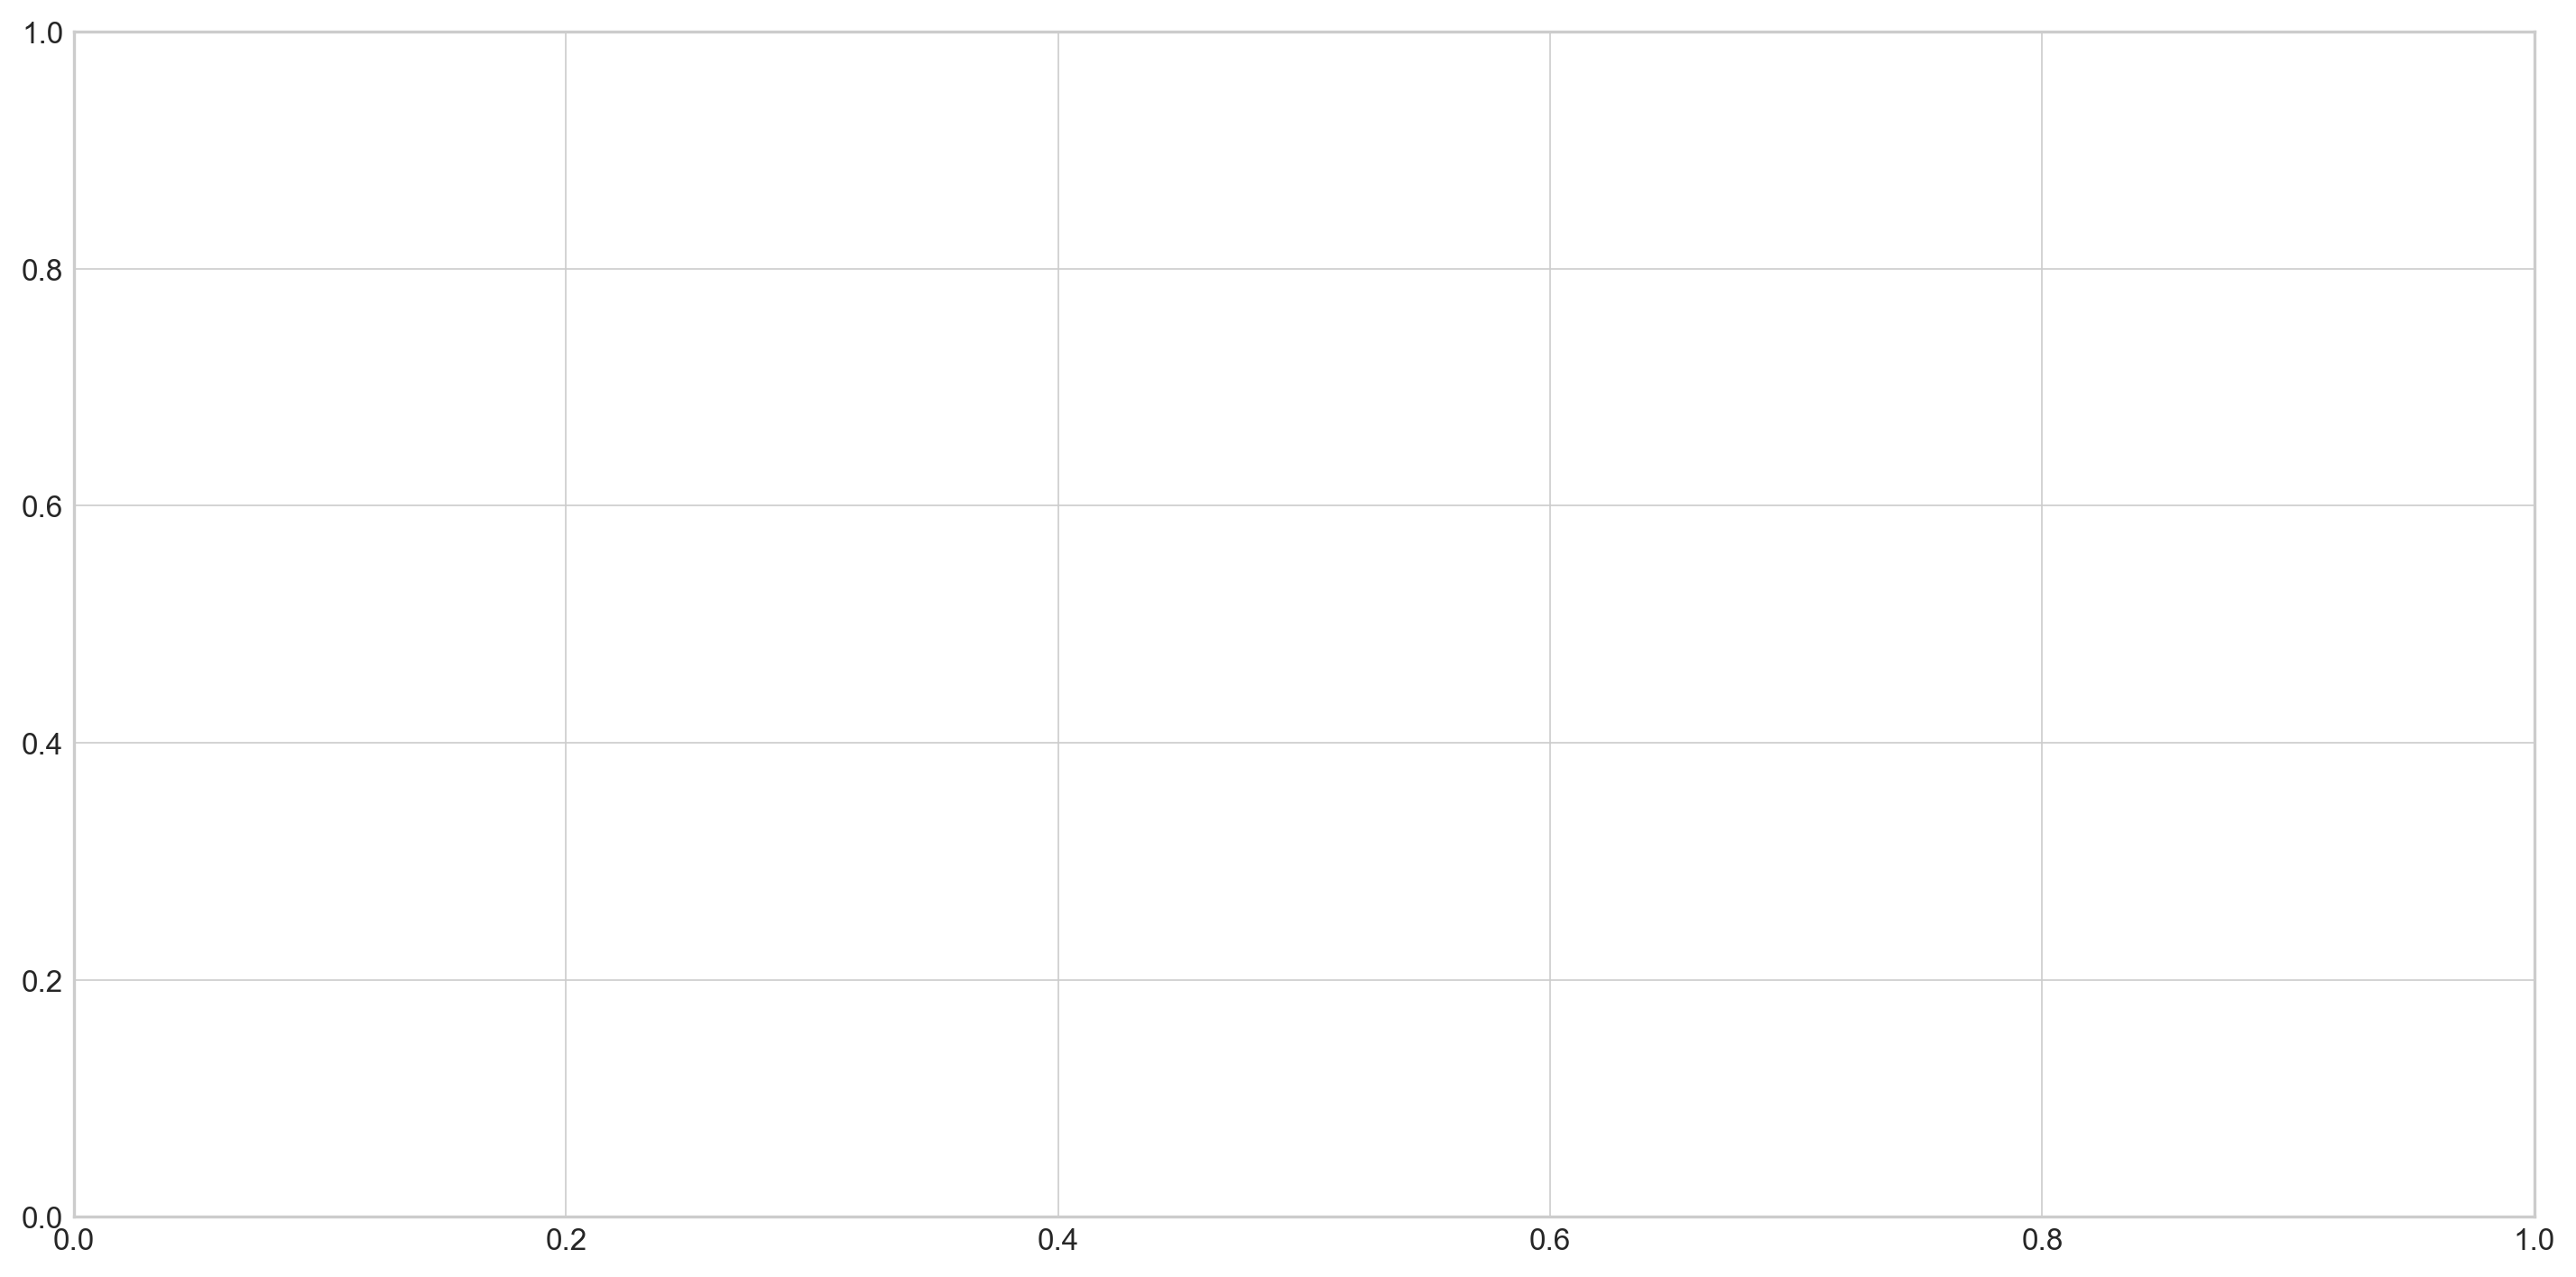

In [53]:
def q1_show_merged_miss():
    '''
    plots daily sales for the X_train
    '''
    #plt.figure(figsize=(12,6))

    # create a temp data frame that will include all data with problematic 2017
    fig, ax = plt.subplots(figsize=(12,6))
    ax = m_weekly.plot(alpha=0.7)
    #plt.title('Daily Purchase Amount', size=18, weight='bold')
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) 
    #ax.set(yticks=[0, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000, 6_000_000, 7_000_000])
    #ax.set(yticklabels=['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M'])
    ax.set(xticks=['2014','2015', '2016', '2017', '2018', '2019', '2020','2021'])
    ax.set(xticklabels=['2014','2015', '2016', '2017', '2018', '2019', '2020','2021'])
    ax.set_xlim(right=pd.Timestamp("2022-01-30 00:00:00"))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #ax.set(yticklabels=['0','8M','16M'])
    plt.xlabel('')
    plt.show()
q1_show_merged_miss()

NameError: name 'm_weekly' is not defined

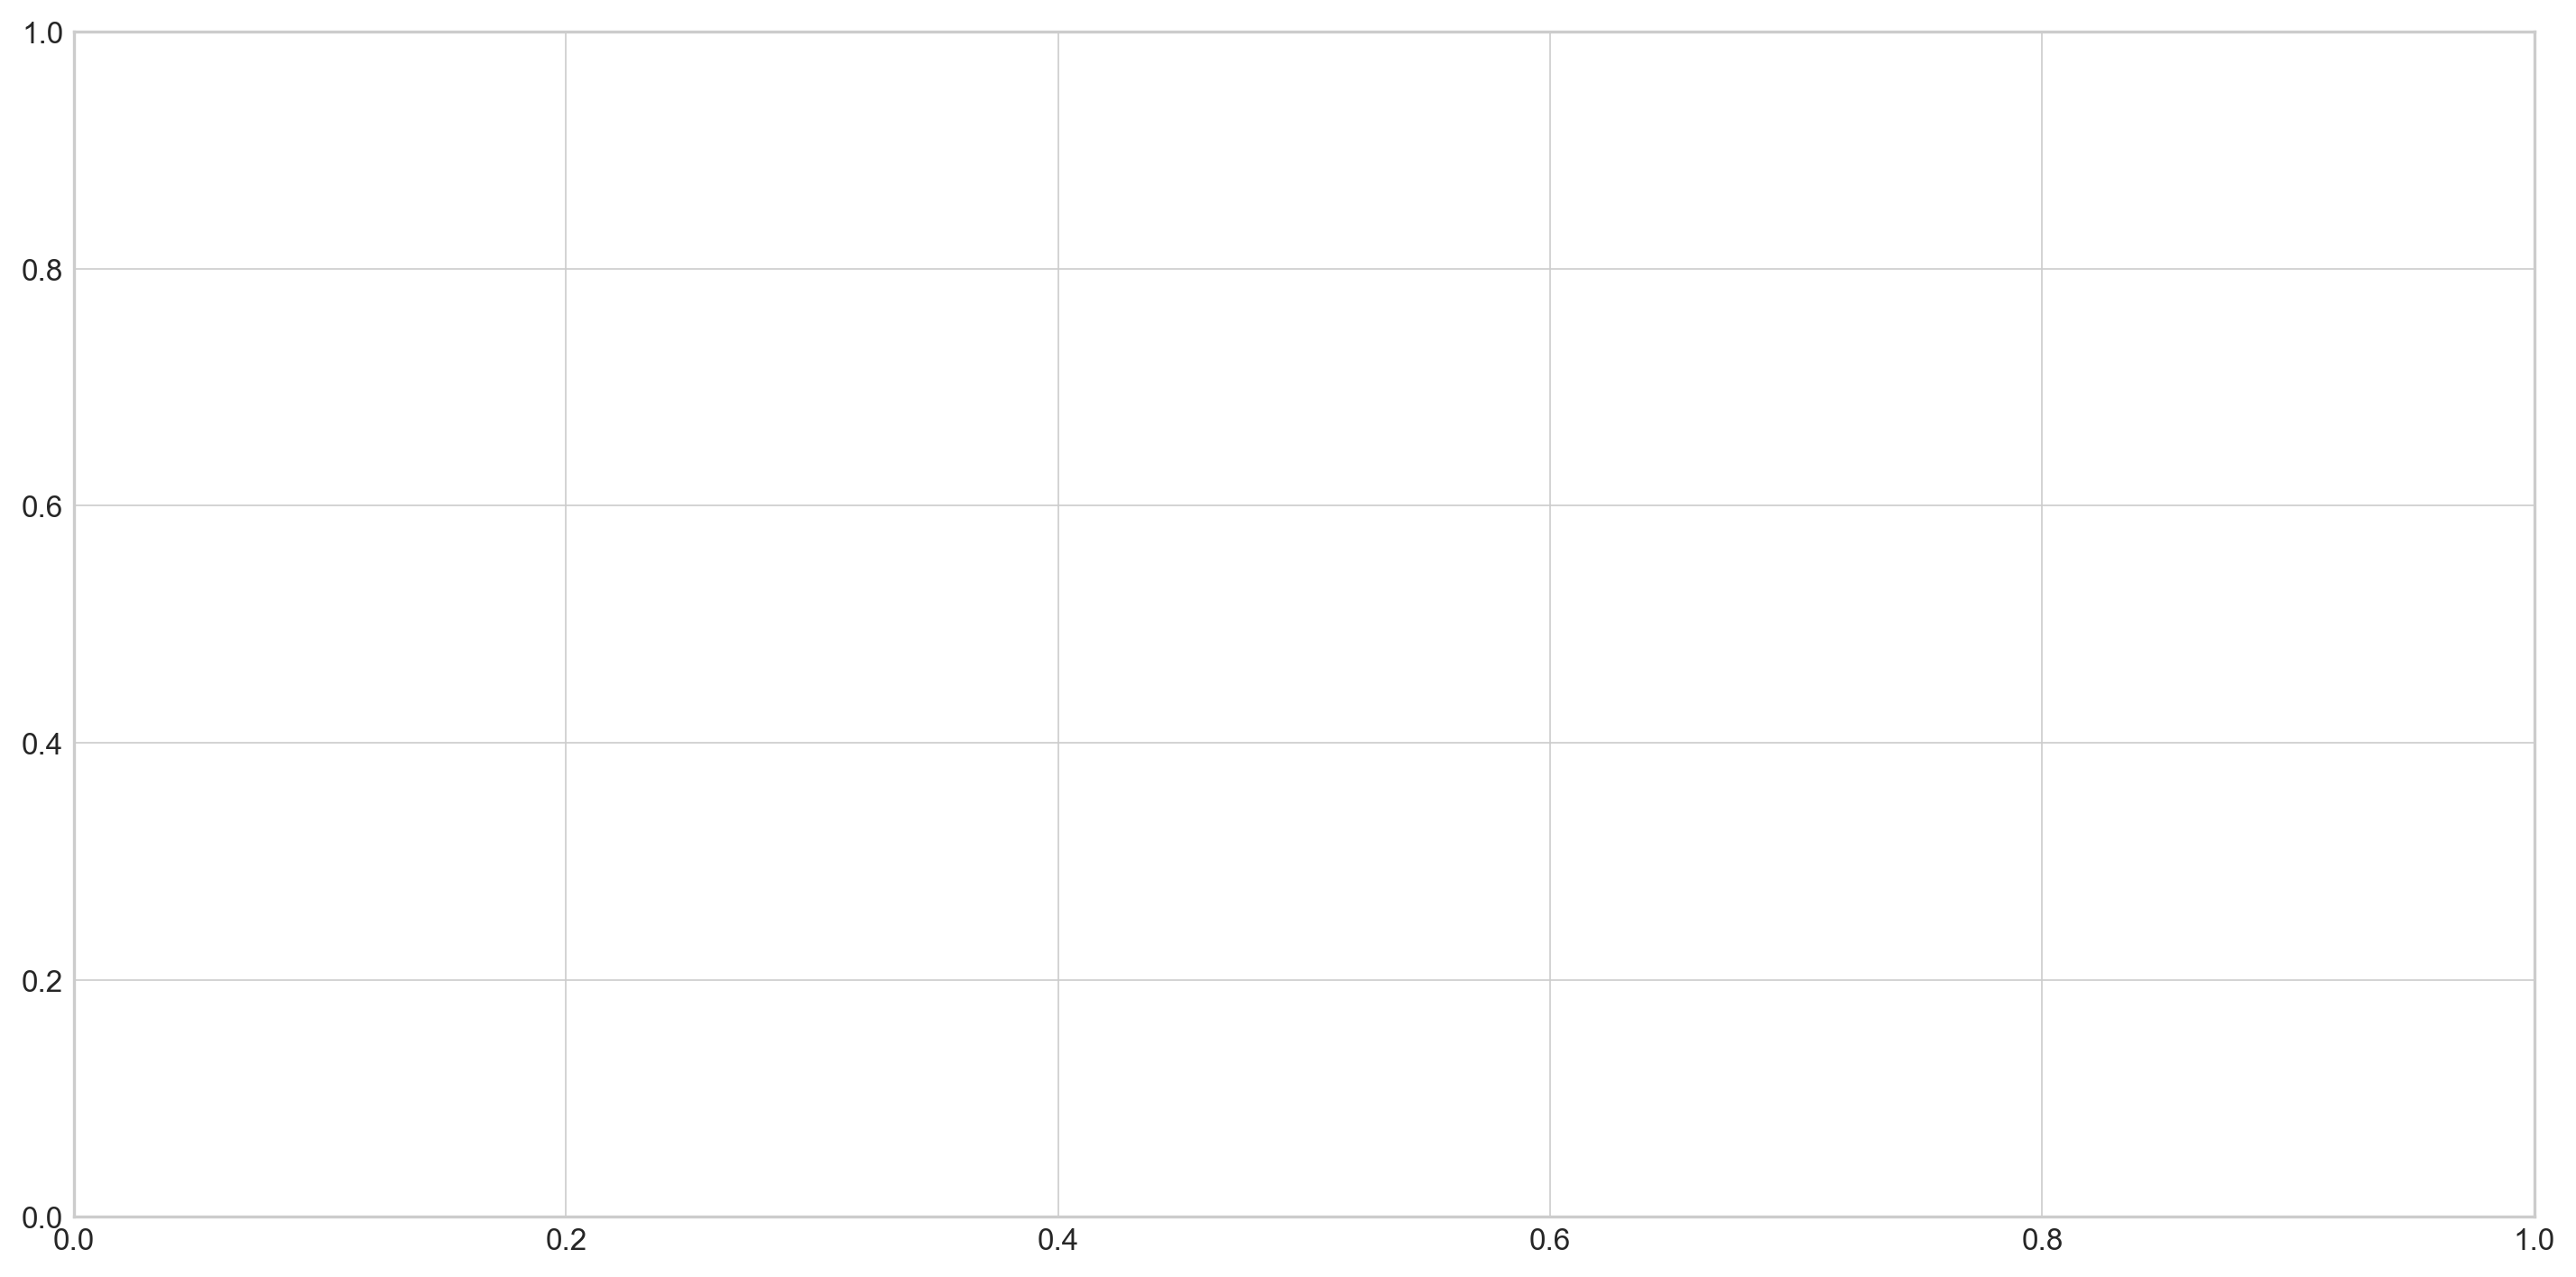

In [54]:
q1_show_merged_miss()